# Trabalho 01

Comparativo entre técnicas de machine learning e deep learning para uma tarefa de classificação no dataset de câncer de mama do scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

### Import dos dados


In [1]:
import sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)


normalizador = StandardScaler()
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
X = normalizador.fit_transform(X)
X

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

### Separação de treino e teste

São separados 20% das observações do dataset como dados de teste. Os dados são separados de maneira a manter a proporção presente do target do dataset original

In [249]:
from sklearn.model_selection import train_test_split

test_size = 0.2
val_size = 0.25


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, stratify= y)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=val_size, stratify= y_train_full)


In [250]:
X_val.shape

(114, 30)

In [251]:
X_train.shape

(341, 30)

In [252]:
X_train_full.shape

(455, 30)

In [253]:
X_test.shape

(114, 30)

In [254]:
X.shape

(569, 30)

### Import dos modelos e definição dos hiperparâmetros que serão ajustados

In [451]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# !conda install -c conda-forge xgboost
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import accuracy_score

dict_algoritmos = {'logistic_regression': LogisticRegression(),
                   'decision_tree'        : DecisionTreeClassifier(),
                   'xgboost'              : xgb.XGBClassifier()}

dict_param_grid_algoritmos = {'logistic_regression' : {'penalty'          : ['l1'], 
                                                       'C'                : uniform(0.01, 100.0), 
                                                       'fit_intercept'    : [False, True],
                                                       'max_iter'         : randint(100,9000),
                                                       'solver'           : ['liblinear', 'saga']},
                             'decision_tree'        : {'splitter'         : ["best", "random"],
                                                       'max_depth'        : randint(3,100) ,
                                                       'min_samples_split': randint(1,30),
                                                       'min_samples_leaf' : randint(1, 30)},
                             'xgboost'              : {'learning_rate'    : uniform(0.05, 0.3),
                                                       'max_depth'        : randint(3,20) ,
                                                       'min_child_weight' : randint(1,7),
                                                       'gamma'            : uniform(0.0, 1.0),
                                                       'colsample_bytree' : uniform(0.1, 1.0)}}

# dicionário para armazenamento dos modelos treinados

dict_resultados_modelos_hiperparametrizados = {}
dict_resultados_modelos_n_hiperparametrizados = {}

# parâmetros da busca randomizada: 

# o número de folds igual a 4 implica em 60% do dataset para treino, 20% para validação e 20% para teste
num_folds = 4 
# número de iterações para a busca randomizada
num_iter = 2000
# objeto que realiza os aplits de forma estratificada
cv = StratifiedKFold(n_splits= num_folds, shuffle= True)

args_random_search = {'cv'                 : cv, 
                      'scoring'            :'f1_macro', 
                      'n_jobs'             : -1,
                      'verbose'            : 10,
                      'n_iter'             : num_iter}

## Hiperparametrização e treinamento do modelo linear
algoritmo: regressão logistica

In [452]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

algoritmo = 'logistic_regression'

y_pred = dict_algoritmos[algoritmo].fit(X_train_full, y_train_full).predict(X_test)

score = accuracy_score(y_test, y_pred)

dict_resultados_modelos_n_hiperparametrizados[algoritmo] = score

args_random_search['estimator']           =  dict_algoritmos[algoritmo]
args_random_search['param_distributions'] = dict_param_grid_algoritmos[algoritmo]
                      
random_search = RandomizedSearchCV(**args_random_search)

random_search.fit(X_train_full, y_train_full)

y_pred = random_search.best_estimator_.fit(X_train_full, y_train_full).predict(X_test)

score = accuracy_score(y_test, y_pred)

dict_resultados_modelos_hiperparametrizados[algoritmo] = score



Fitting 4 folds for each of 2000 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.195

[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1979s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too slow (2.4339s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 4313 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 4402 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 4493 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1931s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1723s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too slow (4.2915s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 4703 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 4802 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1906s.) Setting batch_size=2

## Hiperparametrização e treinamento do modelo de árvore de decisão
algoritmo: Decision tree classifier

In [453]:
algoritmo = 'decision_tree'

y_pred = dict_algoritmos[algoritmo].fit(X_train_full, y_train_full).predict(X_test)

score = accuracy_score(y_test, y_pred)

dict_resultados_modelos_n_hiperparametrizados[algoritmo] = score

args_random_search['estimator']           =  dict_algoritmos[algoritmo]
args_random_search['param_distributions'] = dict_param_grid_algoritmos[algoritmo]
                      
random_search = RandomizedSearchCV(**args_random_search)

random_search.fit(X_train_full, y_train_full)

y_pred = random_search.best_estimator_.fit(X_train_full, y_train_full).predict(X_test)

score = accuracy_score(y_test, y_pred)

dict_resultados_modelos_hiperparametrizados[algoritmo] = score

Fitting 4 folds for each of 2000 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0678s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0699s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0825s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1145s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1842s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1016 tasks      | elapsed:    2.7s
[Parallel(

## Hiperparametrização e treinamento do modelo ensemble
algoritmo: xgboost


In [454]:
algoritmo = 'xgboost'

y_pred = dict_algoritmos[algoritmo].fit(X_train_full, y_train_full).predict(X_test)

score = accuracy_score(y_test, y_pred)

dict_resultados_modelos_n_hiperparametrizados[algoritmo] = score

args_random_search['estimator']           =  dict_algoritmos[algoritmo]
args_random_search['param_distributions'] = dict_param_grid_algoritmos[algoritmo]
                      
random_search = RandomizedSearchCV(**args_random_search)

random_search.fit(X_train_full, y_train_full)

y_pred = random_search.best_estimator_.fit(X_train_full, y_train_full).predict(X_test)

score = accuracy_score(y_test, y_pred)

dict_resultados_modelos_hiperparametrizados[algoritmo] = score

Fitting 4 folds for each of 2000 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1100s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1852s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    8.2s
[Parallel(n_jo

In [455]:
dict_resultados_modelos_n_hiperparametrizados

{'logistic_regression': 0.9736842105263158,
 'decision_tree': 0.956140350877193,
 'xgboost': 0.9824561403508771}

In [456]:
dict_resultados_modelos_hiperparametrizados

{'logistic_regression': 0.9736842105263158,
 'decision_tree': 0.956140350877193,
 'xgboost': 0.9736842105263158}

## Hiperparametrização e treinamento do modelo de rede neural
https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner

### import da biblioteca e verificação de disponibilidade de gpu

In [131]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
# !conda install -c conda-forge keras-tuner
import kerastuner as hp


print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### construção do modelo para busca de hiperparâmetros

In [389]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from kerastuner import HyperParameters as hp
import pandas as pd
def get_model(hp):
    
    
    new_model = Sequential()

    new_model.add(Dense(units = hp.Int('n_units_l1',
                                min_value=32,
                                max_value=512,
                                step=1,
                                default=128),
                        input_dim= X.shape[1],
#                         init='uniform',
                       activation = hp.Choice('dense_activation_l1',
                                              values=['relu', 'tanh', 'sigmoid'],
                                              default='relu')))
           
    new_model.add(Dense(units = hp.Int('n_units_l2',
                                min_value=8,
                                max_value=128,
                                step=1,
                                default=64),
#                         init='uniform',
                   activation = hp.Choice('dense_activation_l2',
                                          values=['relu', 'tanh', 'sigmoid'],
                                          default='relu')))    
   
    new_model.add(Dense(1, activation='sigmoid'))
    
    
    new_model.compile(loss='binary_crossentropy', 
                      optimizer= 'sgd', 
                      metrics=['accuracy'])
    
    return new_model



### instanciação do objeto de busca de hiperparâmetros

In [390]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    get_model,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=10)

### busca de hiperparâmetros

In [391]:
tuner.search(X_train, y_train,
             epochs=100,
             validation_data= (X_val, y_val))

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.7939 - accuracy: 0.53 - ETA: 0s - loss: 0.7604 - accuracy: 0.51 - 2s 163ms/step - loss: 0.7479 - accuracy: 0.5279 - val_loss: 0.6905 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.62 - ETA: 0s - loss: 0.6466 - accuracy: 0.67 - 0s 12ms/step - loss: 0.6466 - accuracy: 0.6716 - val_loss: 0.6050 - val_accuracy: 0.7193
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5760 - accuracy: 0.75 - ETA: 0s - loss: 0.5944 - accuracy: 0.75 - ETA: 0s - loss: 0.5871 - accuracy: 0.75 - 0s 24ms/step - loss: 0.5724 - accuracy: 0.7830 - val_loss: 0.5389 - val_accuracy: 0.8070
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5426 - accuracy: 0.78 - 0s 14ms/step - loss: 0.5143 - accuracy: 0.8211 - val_loss: 0.4857 - val_accuracy: 0.8509
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.78 - ETA: 

Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3902 - accuracy: 0.9091 - val_loss: 0.3419 - val_accuracy: 0.9474
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4109 - accuracy: 0.87 - 0s 7ms/step - loss: 0.3571 - accuracy: 0.9179 - val_loss: 0.3125 - val_accuracy: 0.9474
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.96 - 0s 7ms/step - loss: 0.3288 - accuracy: 0.9296 - val_loss: 0.2882 - val_accuracy: 0.9474
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3055 - accuracy: 0.9296 - val_loss: 0.2682 - val_accuracy: 0.9474
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.90 - 0s 6ms/step - loss: 0.2862 - accuracy: 0.9296 - val_loss: 0.2505 - val_accuracy: 0.9561
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.

Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 1.00 - ETA: 0s - loss: 0.2669 - accuracy: 0.94 - 0s 9ms/step - loss: 0.2640 - accuracy: 0.9413 - val_loss: 0.2337 - val_accuracy: 0.9474
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.93 - 0s 5ms/step - loss: 0.2460 - accuracy: 0.9413 - val_loss: 0.2165 - val_accuracy: 0.9474
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.93 - 0s 6ms/step - loss: 0.2310 - accuracy: 0.9413 - val_loss: 0.2018 - val_accuracy: 0.9474
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.96 - 0s 7ms/step - loss: 0.2184 - accuracy: 0.9413 - val_loss: 0.1893 - val_accuracy: 0.9474
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.90 - 0s 5ms/step - loss: 0.2075 - accuracy: 0.9413 - val_loss: 0.1785 - val_accuracy: 0.9474
Epoch 13/40
11/11 [==========================

11/11 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.93 - 0s 6ms/step - loss: 0.2263 - accuracy: 0.9589 - val_loss: 0.1961 - val_accuracy: 0.9737
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 1.00 - 0s 6ms/step - loss: 0.2153 - accuracy: 0.9619 - val_loss: 0.1850 - val_accuracy: 0.9737
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.93 - 0s 6ms/step - loss: 0.2053 - accuracy: 0.9589 - val_loss: 0.1751 - val_accuracy: 0.9737
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.93 - 0s 5ms/step - loss: 0.1964 - accuracy: 0.9619 - val_loss: 0.1662 - val_accuracy: 0.9737
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.96 - 0s 7ms/step - loss: 0.1884 - accuracy: 0.9619 - val_loss: 0.1584 - val_accuracy: 0.9737
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.96 - 0s

Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 1.00 - 0s 8ms/step - loss: 0.1715 - accuracy: 0.9648 - val_loss: 0.1416 - val_accuracy: 0.9737
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.96 - 0s 6ms/step - loss: 0.1655 - accuracy: 0.9648 - val_loss: 0.1361 - val_accuracy: 0.9737
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.93 - 0s 6ms/step - loss: 0.1601 - accuracy: 0.9648 - val_loss: 0.1310 - val_accuracy: 0.9737
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 1.00 - 0s 6ms/step - loss: 0.1552 - accuracy: 0.9707 - val_loss: 0.1264 - val_accuracy: 0.9737
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.96 - 0s 13ms/step - loss: 0.1507 - accuracy: 0.9707 - val_loss: 0.1221 - val_accuracy: 0.9737
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.1670 - accura

Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.93 - ETA: 0s - loss: 0.1898 - accuracy: 0.94 - 0s 14ms/step - loss: 0.1799 - accuracy: 0.9443 - val_loss: 0.1695 - val_accuracy: 0.9561
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.93 - 0s 7ms/step - loss: 0.1746 - accuracy: 0.9443 - val_loss: 0.1640 - val_accuracy: 0.9649
Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.96 - 0s 6ms/step - loss: 0.1695 - accuracy: 0.9443 - val_loss: 0.1590 - val_accuracy: 0.9649
Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.87 - 0s 8ms/step - loss: 0.1649 - accuracy: 0.9443 - val_loss: 0.1543 - val_accuracy: 0.9649
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.90 - 0s 8ms/step - loss: 0.1604 - accuracy: 0.9443 - val_loss: 0.1499 - val_accuracy: 0.9649
Epoch 28/40
11/11 [=======================

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.68 - ETA: 0s - loss: 0.6639 - accuracy: 0.61 - 0s 24ms/step - loss: 0.6518 - accuracy: 0.6246 - val_loss: 0.6133 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.65 - ETA: 0s - loss: 0.5824 - accuracy: 0.66 - 0s 13ms/step - loss: 0.5936 - accuracy: 0.6364 - val_loss: 0.5749 - val_accuracy: 0.8596
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.75 - 0s 12ms/step - loss: 0.5566 - accuracy: 0.7243 - val_loss: 0.5202 - val_accuracy: 0.7193
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5743 - accuracy: 0.56 - 0s 7ms/step - loss: 0.5182 - accuracy: 0.7155 - val_loss: 0.4830 - val_accuracy: 0.8684
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4673 - accuracy: 0.87 - ETA: 0s - loss: 0.4872 - accuracy: 0.80 - 0s 15ms/step - loss: 0.4872 - accuracy: 0.8035 - 

11/11 [==============================] - ETA: 0s - loss: 0.5829 - accuracy: 0.71 - ETA: 0s - loss: 0.5610 - accuracy: 0.74 - 0s 9ms/step - loss: 0.5550 - accuracy: 0.7595 - val_loss: 0.5330 - val_accuracy: 0.7193
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.68 - ETA: 0s - loss: 0.5268 - accuracy: 0.75 - 0s 15ms/step - loss: 0.5291 - accuracy: 0.7595 - val_loss: 0.5037 - val_accuracy: 0.8158
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.87 - ETA: 0s - loss: 0.5046 - accuracy: 0.79 - 0s 11ms/step - loss: 0.5057 - accuracy: 0.7947 - val_loss: 0.4790 - val_accuracy: 0.8596
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.87 - 0s 7ms/step - loss: 0.4827 - accuracy: 0.8270 - val_loss: 0.4558 - val_accuracy: 0.9035
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4381 - accuracy: 0.93 - 0s 8ms/step - loss: 0.4617 - accuracy: 0.8504 - val_loss: 0.4

11/11 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.68 - ETA: 0s - loss: 0.4666 - accuracy: 0.80 - 0s 10ms/step - loss: 0.4608 - accuracy: 0.8182 - val_loss: 0.4252 - val_accuracy: 0.8772
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4295 - accuracy: 0.90 - 0s 9ms/step - loss: 0.4334 - accuracy: 0.8651 - val_loss: 0.3986 - val_accuracy: 0.8509
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.87 - 0s 8ms/step - loss: 0.4076 - accuracy: 0.8416 - val_loss: 0.3756 - val_accuracy: 0.9386
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.4075 - accuracy: 0.90 - 0s 7ms/step - loss: 0.3866 - accuracy: 0.9003 - val_loss: 0.3498 - val_accuracy: 0.9298
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.84 - 0s 8ms/step - loss: 0.3647 - accuracy: 0.9150 - val_loss: 0.3317 - val_accuracy: 0.8947
Epoch 10/40
11/11 [==============================] - ETA: 

Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.84 - 0s 9ms/step - loss: 0.4303 - accuracy: 0.8651 - val_loss: 0.3986 - val_accuracy: 0.9211
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.93 - ETA: 0s - loss: 0.4216 - accuracy: 0.87 - ETA: 0s - loss: 0.4203 - accuracy: 0.88 - ETA: 0s - loss: 0.4144 - accuracy: 0.89 - 0s 27ms/step - loss: 0.4075 - accuracy: 0.8915 - val_loss: 0.3747 - val_accuracy: 0.8947
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.84 - 0s 9ms/step - loss: 0.3875 - accuracy: 0.9062 - val_loss: 0.3582 - val_accuracy: 0.8860
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.87 - ETA: 0s - loss: 0.3602 - accuracy: 0.87 - ETA: 0s - loss: 0.3728 - accuracy: 0.88 - 0s 18ms/step - loss: 0.3723 - accuracy: 0.8856 - val_loss: 0.3338 - val_accuracy: 0.9123
Epoch 10/40
11/11 [==============================] - ETA: 0s

11/11 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.84 - 0s 8ms/step - loss: 0.5371 - accuracy: 0.7419 - val_loss: 0.5164 - val_accuracy: 0.8860
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.93 - 0s 9ms/step - loss: 0.5122 - accuracy: 0.8123 - val_loss: 0.4822 - val_accuracy: 0.8684
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.87 - 0s 7ms/step - loss: 0.4849 - accuracy: 0.8328 - val_loss: 0.4567 - val_accuracy: 0.8509
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.90 - 0s 7ms/step - loss: 0.4597 - accuracy: 0.8270 - val_loss: 0.4295 - val_accuracy: 0.8772
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.4109 - accuracy: 0.93 - 0s 19ms/step - loss: 0.4370 - accuracy: 0.8739 - val_loss: 0.4046 - val_accuracy: 0.8860
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.90 - 0s 6ms

Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.81 - 0s 9ms/step - loss: 0.3894 - accuracy: 0.8915 - val_loss: 0.3561 - val_accuracy: 0.9211
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.87 - 0s 8ms/step - loss: 0.3736 - accuracy: 0.8915 - val_loss: 0.3374 - val_accuracy: 0.9298
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.87 - 0s 7ms/step - loss: 0.3561 - accuracy: 0.8974 - val_loss: 0.3203 - val_accuracy: 0.9298
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.93 - 0s 7ms/step - loss: 0.3418 - accuracy: 0.9120 - val_loss: 0.3044 - val_accuracy: 0.9298
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.90 - 0s 7ms/step - loss: 0.3265 - accuracy: 0.9091 - val_loss: 0.2905 - val_accuracy: 0.9298
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3496 - accurac

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.8012 - accuracy: 0.31 - 0s 20ms/step - loss: 0.7128 - accuracy: 0.4839 - val_loss: 0.6488 - val_accuracy: 0.7719
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.78 - ETA: 0s - loss: 0.6220 - accuracy: 0.78 - 0s 11ms/step - loss: 0.6215 - accuracy: 0.7830 - val_loss: 0.5859 - val_accuracy: 0.7895
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.78 - 0s 7ms/step - loss: 0.5730 - accuracy: 0.7478 - val_loss: 0.5423 - val_accuracy: 0.7895
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.78 - 0s 10ms/step - loss: 0.5358 - accuracy: 0.7683 - val_loss: 0.5061 - val_accuracy: 0.8246
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.71 - 0s 15ms/step - loss: 0.5040 - accuracy: 0.8152 - val_loss: 0.4740 - val_accuracy: 0.8421
Epoch 6/40
11/11 [==========================

Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.78 - ETA: 0s - loss: 0.4884 - accuracy: 0.79 - 0s 9ms/step - loss: 0.4884 - accuracy: 0.7918 - val_loss: 0.4554 - val_accuracy: 0.8860
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.78 - 0s 7ms/step - loss: 0.4603 - accuracy: 0.8592 - val_loss: 0.4265 - val_accuracy: 0.8947
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.75 - 0s 7ms/step - loss: 0.4352 - accuracy: 0.8798 - val_loss: 0.4010 - val_accuracy: 0.9211
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.93 - ETA: 0s - loss: 0.4170 - accuracy: 0.89 - 0s 15ms/step - loss: 0.4128 - accuracy: 0.8944 - val_loss: 0.3780 - val_accuracy: 0.9298
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.87 - ETA: 0s - loss: 0.4015 - accuracy: 0.89 - 0s 12ms/step - loss: 0.3925 - accuracy: 0.9062 - v

11/11 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.93 - 0s 9ms/step - loss: 0.3592 - accuracy: 0.9150 - val_loss: 0.3262 - val_accuracy: 0.9474
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3709 - accuracy: 0.87 - 0s 6ms/step - loss: 0.3440 - accuracy: 0.9208 - val_loss: 0.3106 - val_accuracy: 0.9474
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3303 - accuracy: 0.9238 - val_loss: 0.2961 - val_accuracy: 0.9474
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3179 - accuracy: 0.9267 - val_loss: 0.2828 - val_accuracy: 0.9474
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.90 - 0s 9ms/step - loss: 0.3064 - accuracy: 0.9326 - val_loss: 0.2706 - val_accuracy: 0.9474
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.96 - 0s

11/11 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.90 - 0s 9ms/step - loss: 0.2640 - accuracy: 0.9296 - val_loss: 0.2251 - val_accuracy: 0.9474
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2560 - accuracy: 0.9267 - val_loss: 0.2170 - val_accuracy: 0.9474
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.90 - 0s 6ms/step - loss: 0.2489 - accuracy: 0.9267 - val_loss: 0.2096 - val_accuracy: 0.9474
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.93 - 0s 6ms/step - loss: 0.2424 - accuracy: 0.9296 - val_loss: 0.2026 - val_accuracy: 0.9561
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.90 - 0s 9ms/step - loss: 0.2359 - accuracy: 0.9296 - val_loss: 0.1961 - val_accuracy: 0.9561
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.87 - 0s

Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.96 - 0s 9ms/step - loss: 0.2286 - accuracy: 0.9413 - val_loss: 0.1849 - val_accuracy: 0.9649
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2237 - accuracy: 0.9413 - val_loss: 0.1797 - val_accuracy: 0.9649
Epoch 28/40
11/11 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.93 - 0s 10ms/step - loss: 0.2188 - accuracy: 0.9413 - val_loss: 0.1748 - val_accuracy: 0.9649
Epoch 29/40
11/11 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2143 - accuracy: 0.9413 - val_loss: 0.1702 - val_accuracy: 0.9649
Epoch 30/40
11/11 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.96 - 0s 7ms/step - loss: 0.2100 - accuracy: 0.9413 - val_loss: 0.1658 - val_accuracy: 0.9649
Epoch 31/40
11/11 [==============================] - ETA: 0s - loss: 0.1868 - accura

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.68 - 0s 18ms/step - loss: 0.6205 - accuracy: 0.6422 - val_loss: 0.5842 - val_accuracy: 0.6316
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.65 - ETA: 0s - loss: 0.5709 - accuracy: 0.66 - 0s 13ms/step - loss: 0.5709 - accuracy: 0.6657 - val_loss: 0.5390 - val_accuracy: 0.7281
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.71 - 0s 11ms/step - loss: 0.5324 - accuracy: 0.7390 - val_loss: 0.5034 - val_accuracy: 0.7632
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.81 - ETA: 0s - loss: 0.4974 - accuracy: 0.74 - 0s 13ms/step - loss: 0.5012 - accuracy: 0.7537 - val_loss: 0.4739 - val_accuracy: 0.8860
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.87 - 0s 10ms/step - loss: 0.4749 - accuracy: 0.8358 - val_loss: 0.4450 - val_accuracy: 0.8860
E

Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.68 - 0s 6ms/step - loss: 0.5395 - accuracy: 0.7713 - val_loss: 0.5134 - val_accuracy: 0.7719
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.78 - 0s 11ms/step - loss: 0.5105 - accuracy: 0.7595 - val_loss: 0.4830 - val_accuracy: 0.8596
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.87 - 0s 7ms/step - loss: 0.4845 - accuracy: 0.8182 - val_loss: 0.4561 - val_accuracy: 0.8860
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.87 - 0s 7ms/step - loss: 0.4604 - accuracy: 0.8387 - val_loss: 0.4320 - val_accuracy: 0.9035
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.93 - 0s 9ms/step - loss: 0.4388 - accuracy: 0.8563 - val_loss: 0.4089 - val_accuracy: 0.9211
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.4238 - accuracy: 0.

Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4183 - accuracy: 0.87 - 0s 7ms/step - loss: 0.4353 - accuracy: 0.8622 - val_loss: 0.4047 - val_accuracy: 0.8947
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.87 - 0s 10ms/step - loss: 0.4153 - accuracy: 0.8592 - val_loss: 0.3824 - val_accuracy: 0.9035
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3964 - accuracy: 0.8768 - val_loss: 0.3620 - val_accuracy: 0.9123
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.96 - 0s 7ms/step - loss: 0.3783 - accuracy: 0.8856 - val_loss: 0.3435 - val_accuracy: 0.9211
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.87 - 0s 9ms/step - loss: 0.3615 - accuracy: 0.9003 - val_loss: 0.3265 - val_accuracy: 0.9298
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.3075 - accuracy:

Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.75 - 0s 7ms/step - loss: 0.4054 - accuracy: 0.8886 - val_loss: 0.3684 - val_accuracy: 0.9035
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.84 - ETA: 0s - loss: 0.3883 - accuracy: 0.89 - 0s 9ms/step - loss: 0.3883 - accuracy: 0.8915 - val_loss: 0.3499 - val_accuracy: 0.9035
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.87 - 0s 7ms/step - loss: 0.3709 - accuracy: 0.8974 - val_loss: 0.3327 - val_accuracy: 0.9123
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.87 - ETA: 0s - loss: 0.3558 - accuracy: 0.90 - 0s 12ms/step - loss: 0.3558 - accuracy: 0.9003 - val_loss: 0.3163 - val_accuracy: 0.9298
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.90 - ETA: 0s - loss: 0.3414 - accuracy: 0.90 - 0s 11ms/step - loss: 0.3414 - accuracy: 0.9091 

11/11 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.87 - 0s 9ms/step - loss: 0.3993 - accuracy: 0.8944 - val_loss: 0.3675 - val_accuracy: 0.9211
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4336 - accuracy: 0.84 - ETA: 0s - loss: 0.3839 - accuracy: 0.90 - 0s 11ms/step - loss: 0.3810 - accuracy: 0.9003 - val_loss: 0.3492 - val_accuracy: 0.9211
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.90 - ETA: 0s - loss: 0.3503 - accuracy: 0.90 - 0s 11ms/step - loss: 0.3664 - accuracy: 0.8944 - val_loss: 0.3317 - val_accuracy: 0.9298
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.78 - 0s 11ms/step - loss: 0.3503 - accuracy: 0.9062 - val_loss: 0.3158 - val_accuracy: 0.9386
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.84 - ETA: 0s - loss: 0.3276 - accuracy: 0.91 - 0s 12ms/step - loss: 0.3357 - accuracy: 0.9120 - val_los

11/11 [==============================] - ETA: 0s - loss: 0.3411 - accuracy: 0.87 - 0s 10ms/step - loss: 0.3275 - accuracy: 0.9003 - val_loss: 0.2866 - val_accuracy: 0.9298
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.90 - 0s 7ms/step - loss: 0.3136 - accuracy: 0.9208 - val_loss: 0.2731 - val_accuracy: 0.9298
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.84 - 0s 10ms/step - loss: 0.3017 - accuracy: 0.9208 - val_loss: 0.2606 - val_accuracy: 0.9298
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.96 - 0s 9ms/step - loss: 0.2926 - accuracy: 0.9120 - val_loss: 0.2513 - val_accuracy: 0.9474
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.87 - 0s 9ms/step - loss: 0.2818 - accuracy: 0.9267 - val_loss: 0.2392 - val_accuracy: 0.9474
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.93 - 

Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.93 - 0s 7ms/step - loss: 0.3326 - accuracy: 0.9150 - val_loss: 0.2917 - val_accuracy: 0.9298
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.78 - 0s 8ms/step - loss: 0.3183 - accuracy: 0.9120 - val_loss: 0.2777 - val_accuracy: 0.9386
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.84 - 0s 8ms/step - loss: 0.3064 - accuracy: 0.9238 - val_loss: 0.2662 - val_accuracy: 0.9474
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2951 - accuracy: 0.9326 - val_loss: 0.2533 - val_accuracy: 0.9386
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.96 - 0s 7ms/step - loss: 0.2853 - accuracy: 0.9355 - val_loss: 0.2426 - val_accuracy: 0.9474
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.3112 - accurac

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.75 - ETA: 0s - loss: 0.6452 - accuracy: 0.73 - 0s 21ms/step - loss: 0.6432 - accuracy: 0.7361 - val_loss: 0.5746 - val_accuracy: 0.8509
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.87 - ETA: 0s - loss: 0.5361 - accuracy: 0.86 - 0s 14ms/step - loss: 0.5361 - accuracy: 0.8680 - val_loss: 0.4828 - val_accuracy: 0.9298
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.84 - ETA: 0s - loss: 0.4627 - accuracy: 0.90 - 0s 29ms/step - loss: 0.4627 - accuracy: 0.9003 - val_loss: 0.4166 - val_accuracy: 0.9298
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4181 - accuracy: 0.93 - ETA: 0s - loss: 0.4081 - accuracy: 0.91 - 0s 23ms/step - loss: 0.4081 - accuracy: 0.9150 - val_loss: 0.3670 - val_accuracy: 0.9386
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.81 - ETA: 0

11/11 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.96 - 0s 9ms/step - loss: 0.3934 - accuracy: 0.9267 - val_loss: 0.3550 - val_accuracy: 0.9649
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.96 - 0s 7ms/step - loss: 0.3531 - accuracy: 0.9326 - val_loss: 0.3176 - val_accuracy: 0.9649
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.96 - ETA: 0s - loss: 0.3203 - accuracy: 0.93 - 0s 9ms/step - loss: 0.3203 - accuracy: 0.9326 - val_loss: 0.2872 - val_accuracy: 0.9737
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2940 - accuracy: 0.9355 - val_loss: 0.2621 - val_accuracy: 0.9737
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.96 - ETA: 0s - loss: 0.2650 - accuracy: 0.95 - 0s 11ms/step - loss: 0.2722 - accuracy: 0.9384 - val_loss: 0.2412 - val_accuracy: 0.9737
Epoch 10/40
11/1

Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.2985 - accuracy: 0.93 - ETA: 0s - loss: 0.2779 - accuracy: 0.94 - 0s 11ms/step - loss: 0.2779 - accuracy: 0.9472 - val_loss: 0.2459 - val_accuracy: 0.9649
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 1.00 - ETA: 0s - loss: 0.2582 - accuracy: 0.95 - 0s 9ms/step - loss: 0.2582 - accuracy: 0.9501 - val_loss: 0.2270 - val_accuracy: 0.9649
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.96 - 0s 7ms/step - loss: 0.2419 - accuracy: 0.9531 - val_loss: 0.2107 - val_accuracy: 0.9649
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2275 - accuracy: 0.9531 - val_loss: 0.1968 - val_accuracy: 0.9649
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2154 - accuracy: 0.9531 - val_loss: 0.1849 - val_accuracy: 0.9649
Ep

Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1933 - accuracy: 0.9384 - val_loss: 0.1619 - val_accuracy: 0.9737
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 1.00 - 0s 8ms/step - loss: 0.1855 - accuracy: 0.9413 - val_loss: 0.1545 - val_accuracy: 0.9737
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.87 - 0s 10ms/step - loss: 0.1786 - accuracy: 0.9472 - val_loss: 0.1477 - val_accuracy: 0.9737
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.93 - 0s 8ms/step - loss: 0.1725 - accuracy: 0.9472 - val_loss: 0.1414 - val_accuracy: 0.9737
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.96 - 0s 7ms/step - loss: 0.1664 - accuracy: 0.9472 - val_loss: 0.1357 - val_accuracy: 0.9737
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2156 - accura

Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1463 - accuracy: 0.9677 - val_loss: 0.1151 - val_accuracy: 0.9737
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1422 - accuracy: 0.9677 - val_loss: 0.1114 - val_accuracy: 0.9737
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.96 - 0s 6ms/step - loss: 0.1383 - accuracy: 0.9707 - val_loss: 0.1079 - val_accuracy: 0.9737
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1348 - accuracy: 0.9707 - val_loss: 0.1048 - val_accuracy: 0.9737
Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.93 - 0s 10ms/step - loss: 0.1314 - accuracy: 0.9707 - val_loss: 0.1019 - val_accuracy: 0.9737
Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.1028 - accura

Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 1.00 - 0s 10ms/step - loss: 0.1308 - accuracy: 0.9648 - val_loss: 0.1014 - val_accuracy: 0.9737
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 1.00 - 0s 7ms/step - loss: 0.1276 - accuracy: 0.9648 - val_loss: 0.0985 - val_accuracy: 0.9737
Epoch 28/40
11/11 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1245 - accuracy: 0.9648 - val_loss: 0.0959 - val_accuracy: 0.9737
Epoch 29/40
11/11 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1218 - accuracy: 0.9677 - val_loss: 0.0933 - val_accuracy: 0.9737
Epoch 30/40
11/11 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1190 - accuracy: 0.9677 - val_loss: 0.0909 - val_accuracy: 0.9737
Epoch 31/40
11/11 [==============================] - ETA: 0s - loss: 0.1737 - accura

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.75 - 0s 17ms/step - loss: 0.8254 - accuracy: 0.6276 - val_loss: 0.7419 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5654 - accuracy: 0.75 - ETA: 0s - loss: 0.7007 - accuracy: 0.62 - 0s 11ms/step - loss: 0.6957 - accuracy: 0.6276 - val_loss: 0.6575 - val_accuracy: 0.6228
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.75 - ETA: 0s - loss: 0.6308 - accuracy: 0.63 - 0s 15ms/step - loss: 0.6378 - accuracy: 0.6276 - val_loss: 0.6166 - val_accuracy: 0.6228
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.68 - ETA: 0s - loss: 0.6070 - accuracy: 0.62 - 0s 13ms/step - loss: 0.6070 - accuracy: 0.6276 - val_loss: 0.5910 - val_accuracy: 0.6228
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.59 - 0s 15ms/step - loss: 0.5857 - accuracy: 0.6481 -

Epoch 40/40
11/11 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.96 - ETA: 0s - loss: 0.2381 - accuracy: 0.95 - 0s 13ms/step - loss: 0.2507 - accuracy: 0.9384 - val_loss: 0.2144 - val_accuracy: 0.9474
Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6627 - accuracy: 0.78 - 0s 16ms/step - loss: 0.6707 - accuracy: 0.6276 - val_loss: 0.6547 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.71 - 0s 7ms/step - loss: 0.6437 - accuracy: 0.6276 - val_loss: 0.6294 - val_accuracy: 0.6228
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.68 - 0s 7ms/step - loss: 0.6215 - accuracy: 0.6364 - val_loss: 0.6069 - val_accuracy: 0.6228
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.50 - ETA: 0s - loss: 0.6026 - accuracy: 0.65 - 0s 15ms/step - loss: 0.6013 - accuracy: 0.6540 - val_loss: 0.5862 - val_accuracy: 0.6491
Ep

Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.50 - 0s 9ms/step - loss: 0.5666 - accuracy: 0.6774 - val_loss: 0.5588 - val_accuracy: 0.6930
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.62 - 0s 6ms/step - loss: 0.5480 - accuracy: 0.6979 - val_loss: 0.5389 - val_accuracy: 0.7105
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.78 - 0s 6ms/step - loss: 0.5301 - accuracy: 0.7126 - val_loss: 0.5199 - val_accuracy: 0.7368
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.71 - 0s 7ms/step - loss: 0.5130 - accuracy: 0.7566 - val_loss: 0.5018 - val_accuracy: 0.7632
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4942 - accuracy: 0.71 - 0s 7ms/step - loss: 0.4971 - accuracy: 0.7742 - val_loss: 0.4842 - val_accuracy: 0.8246
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0

11/11 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.71 - 0s 8ms/step - loss: 0.5247 - accuracy: 0.7537 - val_loss: 0.5077 - val_accuracy: 0.7719
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.96 - 0s 7ms/step - loss: 0.5115 - accuracy: 0.7625 - val_loss: 0.4930 - val_accuracy: 0.8421
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.87 - 0s 6ms/step - loss: 0.4980 - accuracy: 0.7977 - val_loss: 0.4787 - val_accuracy: 0.8421
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.87 - 0s 6ms/step - loss: 0.4851 - accuracy: 0.8065 - val_loss: 0.4650 - val_accuracy: 0.8509
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.81 - 0s 7ms/step - loss: 0.4732 - accuracy: 0.8123 - val_loss: 0.4516 - val_accuracy: 0.8772
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.75 - 0s

Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3815 - accuracy: 0.8798 - val_loss: 0.3484 - val_accuracy: 0.9211
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.93 - 0s 6ms/step - loss: 0.3716 - accuracy: 0.8886 - val_loss: 0.3379 - val_accuracy: 0.9211
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.84 - 0s 7ms/step - loss: 0.3619 - accuracy: 0.8944 - val_loss: 0.3278 - val_accuracy: 0.9211
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.84 - 0s 6ms/step - loss: 0.3530 - accuracy: 0.8974 - val_loss: 0.3181 - val_accuracy: 0.9211
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.90 - 0s 7ms/step - loss: 0.3444 - accuracy: 0.9003 - val_loss: 0.3090 - val_accuracy: 0.9298
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.3584 - accurac

Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.87 - 0s 9ms/step - loss: 0.3614 - accuracy: 0.8944 - val_loss: 0.3298 - val_accuracy: 0.9211
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.87 - 0s 9ms/step - loss: 0.3526 - accuracy: 0.9062 - val_loss: 0.3208 - val_accuracy: 0.9211
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.71 - 0s 8ms/step - loss: 0.3446 - accuracy: 0.8974 - val_loss: 0.3121 - val_accuracy: 0.9211
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.93 - 0s 7ms/step - loss: 0.3363 - accuracy: 0.9120 - val_loss: 0.3038 - val_accuracy: 0.9211
Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.84 - ETA: 0s - loss: 0.3287 - accuracy: 0.91 - 0s 12ms/step - loss: 0.3288 - accuracy: 0.9091 - val_loss: 0.2958 - val_accuracy: 0.9298
Epoch 26/40
11/11 [=======================

Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.4661 - accuracy: 0.75 - 0s 7ms/step - loss: 0.3460 - accuracy: 0.8886 - val_loss: 0.3183 - val_accuracy: 0.9298
Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.3571 - accuracy: 0.84 - 0s 7ms/step - loss: 0.3379 - accuracy: 0.9003 - val_loss: 0.3101 - val_accuracy: 0.9298
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.84 - 0s 7ms/step - loss: 0.3304 - accuracy: 0.9032 - val_loss: 0.3021 - val_accuracy: 0.9298
Epoch 28/40
11/11 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.84 - 0s 8ms/step - loss: 0.3232 - accuracy: 0.9150 - val_loss: 0.2945 - val_accuracy: 0.9298
Epoch 29/40
11/11 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.93 - 0s 6ms/step - loss: 0.3165 - accuracy: 0.9120 - val_loss: 0.2871 - val_accuracy: 0.9298
Epoch 30/40
11/11 [==============================] - ETA: 0s - loss: 0.2647 - accurac

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.7742 - accuracy: 0.21 - 0s 18ms/step - loss: 0.7028 - accuracy: 0.4839 - val_loss: 0.6134 - val_accuracy: 0.8421
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.84 - 0s 9ms/step - loss: 0.5611 - accuracy: 0.9032 - val_loss: 0.4999 - val_accuracy: 0.9474
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.96 - ETA: 0s - loss: 0.4774 - accuracy: 0.93 - 0s 15ms/step - loss: 0.4698 - accuracy: 0.9326 - val_loss: 0.4216 - val_accuracy: 0.9561
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.87 - ETA: 0s - loss: 0.4016 - accuracy: 0.94 - 0s 12ms/step - loss: 0.4044 - accuracy: 0.9384 - val_loss: 0.3638 - val_accuracy: 0.9649
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.93 - 0s 13ms/step - loss: 0.3557 - accuracy: 0.9384 - val_loss: 0.3197 - val_accuracy: 0.9649
Ep

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.65 - ETA: 0s - loss: 0.6028 - accuracy: 0.69 - 0s 17ms/step - loss: 0.6028 - accuracy: 0.6979 - val_loss: 0.5259 - val_accuracy: 0.8421
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.84 - ETA: 0s - loss: 0.4933 - accuracy: 0.87 - 0s 12ms/step - loss: 0.4828 - accuracy: 0.8827 - val_loss: 0.4313 - val_accuracy: 0.9298
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.81 - 0s 10ms/step - loss: 0.4093 - accuracy: 0.9238 - val_loss: 0.3692 - val_accuracy: 0.9474
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.90 - ETA: 0s - loss: 0.3622 - accuracy: 0.93 - 0s 11ms/step - loss: 0.3591 - accuracy: 0.9384 - val_loss: 0.3242 - val_accuracy: 0.9561
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.96 - ETA: 0s - loss: 0.3174 - accuracy: 0.95 - 0s 11m

Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3878 - accuracy: 0.9208 - val_loss: 0.3513 - val_accuracy: 0.9474
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 1.00 - ETA: 0s - loss: 0.3502 - accuracy: 0.92 - 0s 8ms/step - loss: 0.3502 - accuracy: 0.9208 - val_loss: 0.3155 - val_accuracy: 0.9474
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3200 - accuracy: 0.9267 - val_loss: 0.2864 - val_accuracy: 0.9474
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.96 - 0s 8ms/step - loss: 0.2952 - accuracy: 0.9296 - val_loss: 0.2624 - val_accuracy: 0.9474
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.87 - 0s 6ms/step - loss: 0.2749 - accuracy: 0.9296 - val_loss: 0.2422 - val_accuracy: 0.9474
Epoch 9/40
11/11 [==============================

Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.93 - 0s 6ms/step - loss: 0.3090 - accuracy: 0.9179 - val_loss: 0.2776 - val_accuracy: 0.9386
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.96 - 0s 7ms/step - loss: 0.2877 - accuracy: 0.9238 - val_loss: 0.2570 - val_accuracy: 0.9474
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2895 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2697 - accuracy: 0.9267 - val_loss: 0.2393 - val_accuracy: 0.9474
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.96 - 0s 8ms/step - loss: 0.2541 - accuracy: 0.9267 - val_loss: 0.2241 - val_accuracy: 0.9474
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2404 - accuracy: 0.9326 - val_loss: 0.2108 - val_accuracy: 0.9561
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.1965 - accuracy:

Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.90 - 0s 10ms/step - loss: 0.2112 - accuracy: 0.9472 - val_loss: 0.1815 - val_accuracy: 0.9737
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.96 - 0s 6ms/step - loss: 0.2007 - accuracy: 0.9472 - val_loss: 0.1711 - val_accuracy: 0.9737
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.93 - 0s 6ms/step - loss: 0.1914 - accuracy: 0.9501 - val_loss: 0.1618 - val_accuracy: 0.9737
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.90 - 0s 7ms/step - loss: 0.1831 - accuracy: 0.9531 - val_loss: 0.1535 - val_accuracy: 0.9737
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.93 - 0s 8ms/step - loss: 0.1757 - accuracy: 0.9560 - val_loss: 0.1461 - val_accuracy: 0.9737
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.1711 - accura

Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.93 - 0s 6ms/step - loss: 0.1581 - accuracy: 0.9501 - val_loss: 0.1338 - val_accuracy: 0.9649
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.96 - ETA: 0s - loss: 0.1551 - accuracy: 0.95 - 0s 9ms/step - loss: 0.1529 - accuracy: 0.9560 - val_loss: 0.1287 - val_accuracy: 0.9737
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1482 - accuracy: 0.9560 - val_loss: 0.1240 - val_accuracy: 0.9737
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.96 - 0s 6ms/step - loss: 0.1439 - accuracy: 0.9589 - val_loss: 0.1198 - val_accuracy: 0.9737
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 1.00 - 0s 6ms/step - loss: 0.1398 - accuracy: 0.9619 - val_loss: 0.1159 - val_accuracy: 0.9737
Epoch 22/40
11/11 [========================

Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.96 - 0s 7ms/step - loss: 0.1547 - accuracy: 0.9619 - val_loss: 0.1232 - val_accuracy: 0.9737
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.96 - 0s 7ms/step - loss: 0.1496 - accuracy: 0.9619 - val_loss: 0.1185 - val_accuracy: 0.9737
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.93 - 0s 8ms/step - loss: 0.1450 - accuracy: 0.9619 - val_loss: 0.1142 - val_accuracy: 0.9737
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 1.00 - 0s 8ms/step - loss: 0.1408 - accuracy: 0.9648 - val_loss: 0.1104 - val_accuracy: 0.9737
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.93 - ETA: 0s - loss: 0.1570 - accuracy: 0.95 - 0s 12ms/step - loss: 0.1369 - accuracy: 0.9648 - val_loss: 0.1067 - val_accuracy: 0.9737
Epoch 25/40
11/11 [=======================

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.65 - 0s 18ms/step - loss: 0.6617 - accuracy: 0.6276 - val_loss: 0.6570 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.50 - 0s 6ms/step - loss: 0.6529 - accuracy: 0.6276 - val_loss: 0.6504 - val_accuracy: 0.6228
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5953 - accuracy: 0.71 - 0s 7ms/step - loss: 0.6472 - accuracy: 0.6276 - val_loss: 0.6446 - val_accuracy: 0.6228
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.65 - 0s 9ms/step - loss: 0.6420 - accuracy: 0.6276 - val_loss: 0.6389 - val_accuracy: 0.6228
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.56 - 0s 7ms/step - loss: 0.6374 - accuracy: 0.6276 - val_loss: 0.6337 - val_accuracy: 0.6228
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.

Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.75 - ETA: 0s - loss: 0.5758 - accuracy: 0.71 - ETA: 0s - loss: 0.6118 - accuracy: 0.64 - 0s 16ms/step - loss: 0.6189 - accuracy: 0.6276 - val_loss: 0.6141 - val_accuracy: 0.6228
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.53 - 0s 6ms/step - loss: 0.6160 - accuracy: 0.6276 - val_loss: 0.6098 - val_accuracy: 0.6228
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.6295 - accuracy: 0.59 - 0s 7ms/step - loss: 0.6110 - accuracy: 0.6276 - val_loss: 0.6053 - val_accuracy: 0.6228
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.5740 - accuracy: 0.68 - 0s 11ms/step - loss: 0.6068 - accuracy: 0.6276 - val_loss: 0.6010 - val_accuracy: 0.6228
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.62 - ETA: 0s - loss: 0.6031 - accuracy: 0.62 - 0s 13ms/step - loss: 0.6031 - accuracy: 0.6276 - v

11/11 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.81 - 0s 11ms/step - loss: 0.6257 - accuracy: 0.6276 - val_loss: 0.6206 - val_accuracy: 0.6228
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.50 - ETA: 0s - loss: 0.6203 - accuracy: 0.63 - 0s 15ms/step - loss: 0.6216 - accuracy: 0.6276 - val_loss: 0.6155 - val_accuracy: 0.6228
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.68 - ETA: 0s - loss: 0.6158 - accuracy: 0.63 - 0s 16ms/step - loss: 0.6170 - accuracy: 0.6276 - val_loss: 0.6105 - val_accuracy: 0.6228
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.6427 - accuracy: 0.56 - ETA: 0s - loss: 0.6123 - accuracy: 0.62 - 0s 12ms/step - loss: 0.6123 - accuracy: 0.6276 - val_loss: 0.6055 - val_accuracy: 0.6228
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.62 - 0s 9ms/step - loss: 0.6068 - accuracy: 0.6276 - val_los

Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.65 - ETA: 0s - loss: 0.6060 - accuracy: 0.62 - 0s 12ms/step - loss: 0.6032 - accuracy: 0.6305 - val_loss: 0.5959 - val_accuracy: 0.6228
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.5932 - accuracy: 0.65 - 0s 7ms/step - loss: 0.5997 - accuracy: 0.6276 - val_loss: 0.5918 - val_accuracy: 0.6316
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.59 - ETA: 0s - loss: 0.5958 - accuracy: 0.63 - 0s 12ms/step - loss: 0.5957 - accuracy: 0.6334 - val_loss: 0.5878 - val_accuracy: 0.6316
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.65 - 0s 10ms/step - loss: 0.5921 - accuracy: 0.6305 - val_loss: 0.5837 - val_accuracy: 0.6316
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.65 - 0s 9ms/step - loss: 0.5882 - accuracy: 0.6393 - val_loss: 0.5796 - val_accuracy: 0.631

Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.68 - 0s 7ms/step - loss: 0.6127 - accuracy: 0.6276 - val_loss: 0.6080 - val_accuracy: 0.6228
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.59 - ETA: 0s - loss: 0.6131 - accuracy: 0.61 - 0s 12ms/step - loss: 0.6087 - accuracy: 0.6276 - val_loss: 0.6039 - val_accuracy: 0.6228
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.81 - 0s 9ms/step - loss: 0.6049 - accuracy: 0.6276 - val_loss: 0.5997 - val_accuracy: 0.6228
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.71 - 0s 7ms/step - loss: 0.6009 - accuracy: 0.6276 - val_loss: 0.5954 - val_accuracy: 0.6316
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.65 - ETA: 0s - loss: 0.5892 - accuracy: 0.64 - 0s 13ms/step - loss: 0.5967 - accuracy: 0.6276 - val_loss: 0.5912 - val_accuracy: 0.6316

Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.53 - 0s 8ms/step - loss: 0.5966 - accuracy: 0.6364 - val_loss: 0.5886 - val_accuracy: 0.6316
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.65 - 0s 7ms/step - loss: 0.5926 - accuracy: 0.6422 - val_loss: 0.5842 - val_accuracy: 0.6316
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.59 - 0s 10ms/step - loss: 0.5886 - accuracy: 0.6393 - val_loss: 0.5798 - val_accuracy: 0.6316
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.53 - 0s 7ms/step - loss: 0.5843 - accuracy: 0.6452 - val_loss: 0.5754 - val_accuracy: 0.6491
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.59 - ETA: 0s - loss: 0.5783 - accuracy: 0.66 - 0s 11ms/step - loss: 0.5799 - accuracy: 0.6540 - val_loss: 0.5709 - val_accuracy: 0.6579
Epoch 18/40
11/11 [======================

11/11 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.75 - ETA: 0s - loss: 0.5710 - accuracy: 0.68 - 0s 12ms/step - loss: 0.5997 - accuracy: 0.6276 - val_loss: 0.5942 - val_accuracy: 0.6228
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.59 - 0s 7ms/step - loss: 0.5964 - accuracy: 0.6276 - val_loss: 0.5901 - val_accuracy: 0.6316
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.6300 - accuracy: 0.56 - 0s 8ms/step - loss: 0.5926 - accuracy: 0.6364 - val_loss: 0.5862 - val_accuracy: 0.6316
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.65 - 0s 7ms/step - loss: 0.5884 - accuracy: 0.6334 - val_loss: 0.5822 - val_accuracy: 0.6316
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.71 - 0s 8ms/step - loss: 0.5851 - accuracy: 0.6334 - val_loss: 0.5781 - val_accuracy: 0.6404
Epoch 22/40
11/11 [==============================] - E

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.68 - ETA: 0s - loss: 0.6583 - accuracy: 0.62 - 0s 18ms/step - loss: 0.6583 - accuracy: 0.6276 - val_loss: 0.6019 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.56 - 0s 11ms/step - loss: 0.5930 - accuracy: 0.6422 - val_loss: 0.5603 - val_accuracy: 0.6842
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6044 - accuracy: 0.59 - ETA: 0s - loss: 0.5605 - accuracy: 0.67 - 0s 14ms/step - loss: 0.5556 - accuracy: 0.6833 - val_loss: 0.5224 - val_accuracy: 0.7632
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.78 - ETA: 0s - loss: 0.5252 - accuracy: 0.73 - 0s 12ms/step - loss: 0.5224 - accuracy: 0.7478 - val_loss: 0.4896 - val_accuracy: 0.8596
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4757 - accuracy: 0.84 - ETA: 0s - loss: 0.4890 - accuracy: 0.80 - 0s 13m

Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.59 - 0s 7ms/step - loss: 0.5825 - accuracy: 0.6452 - val_loss: 0.5429 - val_accuracy: 0.7105
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.65 - ETA: 0s - loss: 0.5518 - accuracy: 0.71 - 0s 12ms/step - loss: 0.5403 - accuracy: 0.7067 - val_loss: 0.5015 - val_accuracy: 0.8070
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.84 - 0s 8ms/step - loss: 0.5025 - accuracy: 0.8006 - val_loss: 0.4612 - val_accuracy: 0.8596
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.90 - 0s 6ms/step - loss: 0.4687 - accuracy: 0.8211 - val_loss: 0.4275 - val_accuracy: 0.8860
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.96 - 0s 7ms/step - loss: 0.4399 - accuracy: 0.8534 - val_loss: 0.4018 - val_accuracy: 0.9298
Epoch 8/40
11/11 [=============================

Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.87 - 0s 7ms/step - loss: 0.4016 - accuracy: 0.8974 - val_loss: 0.3687 - val_accuracy: 0.9211
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.3999 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3836 - accuracy: 0.8944 - val_loss: 0.3506 - val_accuracy: 0.9386
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3658 - accuracy: 0.9120 - val_loss: 0.3309 - val_accuracy: 0.9298
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.93 - 0s 7ms/step - loss: 0.3496 - accuracy: 0.9091 - val_loss: 0.3141 - val_accuracy: 0.9298
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.90 - ETA: 0s - loss: 0.3475 - accuracy: 0.90 - 0s 11ms/step - loss: 0.3352 - accuracy: 0.9208 - val_loss: 0.2989 - val_accuracy: 0.9298
Epoch 15/40
11/11 [=======================

Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3461 - accuracy: 0.9032 - val_loss: 0.3096 - val_accuracy: 0.9298
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 1.00 - 0s 10ms/step - loss: 0.3321 - accuracy: 0.9150 - val_loss: 0.2953 - val_accuracy: 0.9298
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.90 - ETA: 0s - loss: 0.3194 - accuracy: 0.91 - 0s 11ms/step - loss: 0.3194 - accuracy: 0.9120 - val_loss: 0.2826 - val_accuracy: 0.9474
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3091 - accuracy: 0.9179 - val_loss: 0.2701 - val_accuracy: 0.9298
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.87 - 0s 10ms/step - loss: 0.2979 - accuracy: 0.9179 - val_loss: 0.2588 - val_accuracy: 0.9298
Epoch 18/40
11/11 [=====================

Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.96 - 0s 10ms/step - loss: 0.3112 - accuracy: 0.9238 - val_loss: 0.2694 - val_accuracy: 0.9386
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2992 - accuracy: 0.9208 - val_loss: 0.2582 - val_accuracy: 0.9561
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.90 - ETA: 0s - loss: 0.2904 - accuracy: 0.92 - 0s 13ms/step - loss: 0.2904 - accuracy: 0.9267 - val_loss: 0.2469 - val_accuracy: 0.9561
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2805 - accuracy: 0.9296 - val_loss: 0.2372 - val_accuracy: 0.9474
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2710 - accuracy: 0.9267 - val_loss: 0.2285 - val_accuracy: 0.9649
Epoch 21/40
11/11 [======================

Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.87 - 0s 5ms/step - loss: 0.3100 - accuracy: 0.9150 - val_loss: 0.2716 - val_accuracy: 0.9298
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.84 - 0s 6ms/step - loss: 0.3001 - accuracy: 0.9208 - val_loss: 0.2605 - val_accuracy: 0.9298
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2887 - accuracy: 0.9120 - val_loss: 0.2500 - val_accuracy: 0.9474
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.3801 - accuracy: 0.84 - 0s 7ms/step - loss: 0.2800 - accuracy: 0.9326 - val_loss: 0.2404 - val_accuracy: 0.9474
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2724 - accuracy: 0.9326 - val_loss: 0.2316 - val_accuracy: 0.9561
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.2468 - accurac

Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.96 - 0s 7ms/step - loss: 0.2428 - accuracy: 0.9326 - val_loss: 0.1996 - val_accuracy: 0.9649
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.90 - 0s 7ms/step - loss: 0.2358 - accuracy: 0.9296 - val_loss: 0.1922 - val_accuracy: 0.9649
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.84 - 0s 9ms/step - loss: 0.2288 - accuracy: 0.9326 - val_loss: 0.1876 - val_accuracy: 0.9649
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.90 - ETA: 0s - loss: 0.2233 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2237 - accuracy: 0.9296 - val_loss: 0.1799 - val_accuracy: 0.9737
Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.93 - ETA: 0s - loss: 0.2180 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2183 - accuracy: 0.9326 - val_loss: 0.1742 - val_accuracy: 0.9649
E

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.62 - 0s 16ms/step - loss: 0.6419 - accuracy: 0.6276 - val_loss: 0.6025 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.59 - ETA: 0s - loss: 0.5826 - accuracy: 0.62 - 0s 13ms/step - loss: 0.5806 - accuracy: 0.6276 - val_loss: 0.5430 - val_accuracy: 0.6667
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.75 - 0s 12ms/step - loss: 0.5303 - accuracy: 0.6862 - val_loss: 0.4949 - val_accuracy: 0.7193
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.75 - ETA: 0s - loss: 0.4885 - accuracy: 0.75 - 0s 13ms/step - loss: 0.4895 - accuracy: 0.7566 - val_loss: 0.4550 - val_accuracy: 0.8158
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.75 - ETA: 0s - loss: 0.4449 - accuracy: 0.80 - 0s 12ms/step - loss: 0.4557 - accuracy: 0.8065 -

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.8117 - accuracy: 0.28 - ETA: 0s - loss: 0.7365 - accuracy: 0.39 - 0s 15ms/step - loss: 0.7264 - accuracy: 0.4252 - val_loss: 0.6487 - val_accuracy: 0.8158
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.75 - 0s 6ms/step - loss: 0.6122 - accuracy: 0.8915 - val_loss: 0.5569 - val_accuracy: 0.9386
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.87 - ETA: 0s - loss: 0.5585 - accuracy: 0.90 - 0s 12ms/step - loss: 0.5390 - accuracy: 0.9091 - val_loss: 0.4927 - val_accuracy: 0.9123
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.87 - ETA: 0s - loss: 0.4837 - accuracy: 0.89 - 0s 10ms/step - loss: 0.4862 - accuracy: 0.8915 - val_loss: 0.4456 - val_accuracy: 0.9123
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.78 - ETA: 0s - loss: 0.4468 - accuracy: 0.90 - 0s 9ms/

11/11 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.90 - 0s 8ms/step - loss: 0.4236 - accuracy: 0.9032 - val_loss: 0.3861 - val_accuracy: 0.9298
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.87 - ETA: 0s - loss: 0.3985 - accuracy: 0.91 - 0s 8ms/step - loss: 0.3985 - accuracy: 0.9120 - val_loss: 0.3606 - val_accuracy: 0.9298
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.90 - 0s 5ms/step - loss: 0.3763 - accuracy: 0.9179 - val_loss: 0.3386 - val_accuracy: 0.9386
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.93 - 0s 7ms/step - loss: 0.3572 - accuracy: 0.9208 - val_loss: 0.3191 - val_accuracy: 0.9386
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.93 - 0s 5ms/step - loss: 0.3404 - accuracy: 0.9296 - val_loss: 0.3020 - val_accuracy: 0.9386
Epoch 11/40
11/11 [==============================] - ETA: 

11/11 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.90 - 0s 10ms/step - loss: 0.3044 - accuracy: 0.9326 - val_loss: 0.2628 - val_accuracy: 0.9474
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 1.00 - 0s 6ms/step - loss: 0.2923 - accuracy: 0.9326 - val_loss: 0.2506 - val_accuracy: 0.9474
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.84 - 0s 6ms/step - loss: 0.2816 - accuracy: 0.9296 - val_loss: 0.2396 - val_accuracy: 0.9474
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 1.00 - 0s 6ms/step - loss: 0.2720 - accuracy: 0.9355 - val_loss: 0.2296 - val_accuracy: 0.9561
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.90 - 0s 6ms/step - loss: 0.2628 - accuracy: 0.9355 - val_loss: 0.2204 - val_accuracy: 0.9561
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.87 - 0

11/11 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.96 - ETA: 0s - loss: 0.2685 - accuracy: 0.94 - 0s 10ms/step - loss: 0.2734 - accuracy: 0.9384 - val_loss: 0.2335 - val_accuracy: 0.9649
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.87 - 0s 9ms/step - loss: 0.2642 - accuracy: 0.9413 - val_loss: 0.2238 - val_accuracy: 0.9649
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2554 - accuracy: 0.9413 - val_loss: 0.2150 - val_accuracy: 0.9649
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.87 - 0s 6ms/step - loss: 0.2476 - accuracy: 0.9413 - val_loss: 0.2069 - val_accuracy: 0.9649
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.90 - 0s 7ms/step - loss: 0.2403 - accuracy: 0.9413 - val_loss: 0.1994 - val_accuracy: 0.9649
Epoch 20/40
11/11 [==============================] - E

Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.96 - ETA: 0s - loss: 0.2197 - accuracy: 0.93 - 0s 10ms/step - loss: 0.2197 - accuracy: 0.9384 - val_loss: 0.1817 - val_accuracy: 0.9649
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.96 - ETA: 0s - loss: 0.2143 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2143 - accuracy: 0.9384 - val_loss: 0.1762 - val_accuracy: 0.9649
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.96 - 0s 7ms/step - loss: 0.2093 - accuracy: 0.9384 - val_loss: 0.1711 - val_accuracy: 0.9649
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.93 - ETA: 0s - loss: 0.2044 - accuracy: 0.94 - 0s 9ms/step - loss: 0.2045 - accuracy: 0.9413 - val_loss: 0.1664 - val_accuracy: 0.9649
Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2001 - accuracy: 0.9413 

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.59 - ETA: 0s - loss: 0.6543 - accuracy: 0.63 - 0s 21ms/step - loss: 0.6522 - accuracy: 0.6276 - val_loss: 0.6210 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.56 - 0s 8ms/step - loss: 0.5969 - accuracy: 0.6393 - val_loss: 0.5665 - val_accuracy: 0.6667
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.68 - ETA: 0s - loss: 0.5505 - accuracy: 0.70 - 0s 14ms/step - loss: 0.5505 - accuracy: 0.7067 - val_loss: 0.5200 - val_accuracy: 0.7719
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.84 - ETA: 0s - loss: 0.5097 - accuracy: 0.77 - 0s 13ms/step - loss: 0.5109 - accuracy: 0.7742 - val_loss: 0.4804 - val_accuracy: 0.8246
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.75 - ETA: 0s - loss: 0.4989 - accuracy: 0.80 - 0s 15ms

Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.87 - 0s 7ms/step - loss: 0.5101 - accuracy: 0.8475 - val_loss: 0.4664 - val_accuracy: 0.8860
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.90 - ETA: 0s - loss: 0.4691 - accuracy: 0.85 - 0s 9ms/step - loss: 0.4663 - accuracy: 0.8592 - val_loss: 0.4254 - val_accuracy: 0.9035
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.84 - 0s 5ms/step - loss: 0.4313 - accuracy: 0.8768 - val_loss: 0.3915 - val_accuracy: 0.9123
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.87 - 0s 5ms/step - loss: 0.4024 - accuracy: 0.8974 - val_loss: 0.3625 - val_accuracy: 0.9123
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.93 - ETA: 0s - loss: 0.3821 - accuracy: 0.90 - 0s 28ms/step - loss: 0.3776 - accuracy: 0.9091 - val_loss: 0.3375 - val_accuracy: 0.9298
Epoch

Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.96 - 0s 5ms/step - loss: 0.3681 - accuracy: 0.9179 - val_loss: 0.3333 - val_accuracy: 0.9298
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.87 - 0s 8ms/step - loss: 0.3473 - accuracy: 0.9179 - val_loss: 0.3123 - val_accuracy: 0.9386
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.90 - 0s 5ms/step - loss: 0.3301 - accuracy: 0.9296 - val_loss: 0.2938 - val_accuracy: 0.9474
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.84 - ETA: 0s - loss: 0.3081 - accuracy: 0.92 - 0s 14ms/step - loss: 0.3132 - accuracy: 0.9296 - val_loss: 0.2774 - val_accuracy: 0.9474
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2995 - accuracy: 0.9326 - val_loss: 0.2629 - val_accuracy: 0.9561
Epoch 13/40
11/11 [=========================

Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.84 - 0s 7ms/step - loss: 0.3040 - accuracy: 0.9267 - val_loss: 0.2670 - val_accuracy: 0.9474
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.96 - 0s 5ms/step - loss: 0.2935 - accuracy: 0.9326 - val_loss: 0.2558 - val_accuracy: 0.9386
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.87 - 0s 7ms/step - loss: 0.2832 - accuracy: 0.9326 - val_loss: 0.2455 - val_accuracy: 0.9386
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.93 - ETA: 0s - loss: 0.2754 - accuracy: 0.93 - 0s 13ms/step - loss: 0.2739 - accuracy: 0.9355 - val_loss: 0.2360 - val_accuracy: 0.9474
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.2643 - accuracy: 0.90 - 0s 5ms/step - loss: 0.2656 - accuracy: 0.9355 - val_loss: 0.2273 - val_accuracy: 0.9474
Epoch 19/40
11/11 [=======================

Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.2429 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2498 - accuracy: 0.9384 - val_loss: 0.2070 - val_accuracy: 0.9649
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.90 - 0s 10ms/step - loss: 0.2426 - accuracy: 0.9413 - val_loss: 0.1996 - val_accuracy: 0.9649
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 1.00 - 0s 7ms/step - loss: 0.2359 - accuracy: 0.9384 - val_loss: 0.1927 - val_accuracy: 0.9737
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.96 - ETA: 0s - loss: 0.2314 - accuracy: 0.94 - 0s 10ms/step - loss: 0.2296 - accuracy: 0.9413 - val_loss: 0.1863 - val_accuracy: 0.9737
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 1.00 - 0s 9ms/step - loss: 0.2237 - accuracy: 0.9384 - val_loss: 0.1803 - val_accuracy: 0.9737
Epoch 23/40
11/11 [======================

Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2527 - accuracy: 0.9326 - val_loss: 0.2114 - val_accuracy: 0.9561
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.87 - 0s 5ms/step - loss: 0.2458 - accuracy: 0.9326 - val_loss: 0.2043 - val_accuracy: 0.9561
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2394 - accuracy: 0.9326 - val_loss: 0.1977 - val_accuracy: 0.9561
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2333 - accuracy: 0.9326 - val_loss: 0.1916 - val_accuracy: 0.9561
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.96 - 0s 6ms/step - loss: 0.2276 - accuracy: 0.9326 - val_loss: 0.1858 - val_accuracy: 0.9561
Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.1697 - accurac

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.59 - 0s 22ms/step - loss: 0.6542 - accuracy: 0.6364 - val_loss: 0.6265 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.68 - 0s 7ms/step - loss: 0.6155 - accuracy: 0.6481 - val_loss: 0.5894 - val_accuracy: 0.6579
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.68 - ETA: 0s - loss: 0.5775 - accuracy: 0.68 - 0s 18ms/step - loss: 0.5830 - accuracy: 0.6657 - val_loss: 0.5560 - val_accuracy: 0.7105
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.65 - ETA: 0s - loss: 0.5532 - accuracy: 0.73 - 0s 17ms/step - loss: 0.5532 - accuracy: 0.7361 - val_loss: 0.5256 - val_accuracy: 0.7632
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.62 - 0s 11ms/step - loss: 0.5269 - accuracy: 0.7683 - val_loss: 0.4981 - val_accuracy: 0.7719
Ep

Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.71 - ETA: 0s - loss: 0.5998 - accuracy: 0.63 - 0s 10ms/step - loss: 0.6001 - accuracy: 0.6305 - val_loss: 0.5720 - val_accuracy: 0.6316
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.62 - ETA: 0s - loss: 0.5661 - accuracy: 0.67 - 0s 10ms/step - loss: 0.5661 - accuracy: 0.6716 - val_loss: 0.5371 - val_accuracy: 0.7105
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.62 - ETA: 0s - loss: 0.5350 - accuracy: 0.71 - 0s 9ms/step - loss: 0.5350 - accuracy: 0.7126 - val_loss: 0.5056 - val_accuracy: 0.8158
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.78 - 0s 9ms/step - loss: 0.5075 - accuracy: 0.7742 - val_loss: 0.4765 - val_accuracy: 0.8421
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.75 - 0s 11ms/step - loss: 0.4821 - accuracy: 0.8065 - v

Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.65 - 0s 7ms/step - loss: 0.5646 - accuracy: 0.6921 - val_loss: 0.5346 - val_accuracy: 0.7281
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.71 - 0s 7ms/step - loss: 0.5398 - accuracy: 0.7273 - val_loss: 0.5080 - val_accuracy: 0.7807
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.62 - 0s 8ms/step - loss: 0.5158 - accuracy: 0.7595 - val_loss: 0.4836 - val_accuracy: 0.8333
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.71 - 0s 5ms/step - loss: 0.4939 - accuracy: 0.7918 - val_loss: 0.4608 - val_accuracy: 0.8421
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.4646 - accuracy: 0.84 - 0s 5ms/step - loss: 0.4734 - accuracy: 0.8123 - val_loss: 0.4391 - val_accuracy: 0.8596
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.9

11/11 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.93 - 0s 6ms/step - loss: 0.4273 - accuracy: 0.8944 - val_loss: 0.3939 - val_accuracy: 0.9211
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.84 - 0s 8ms/step - loss: 0.4063 - accuracy: 0.8974 - val_loss: 0.3720 - val_accuracy: 0.9298
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.87 - 0s 14ms/step - loss: 0.3866 - accuracy: 0.9150 - val_loss: 0.3518 - val_accuracy: 0.9298
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.87 - ETA: 0s - loss: 0.3704 - accuracy: 0.91 - 0s 9ms/step - loss: 0.3685 - accuracy: 0.9150 - val_loss: 0.3333 - val_accuracy: 0.9386
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.84 - ETA: 0s - loss: 0.3605 - accuracy: 0.91 - 0s 11ms/step - loss: 0.3519 - accuracy: 0.9179 - val_loss: 0.3162 - val_accuracy: 0.9386
Epoch 13/40


Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.90 - 0s 6ms/step - loss: 0.4396 - accuracy: 0.8680 - val_loss: 0.4126 - val_accuracy: 0.8947
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.78 - ETA: 0s - loss: 0.4225 - accuracy: 0.87 - 0s 9ms/step - loss: 0.4225 - accuracy: 0.8739 - val_loss: 0.3942 - val_accuracy: 0.9035
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.90 - ETA: 0s - loss: 0.4047 - accuracy: 0.88 - 0s 24ms/step - loss: 0.4065 - accuracy: 0.8798 - val_loss: 0.3770 - val_accuracy: 0.9123
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.75 - ETA: 0s - loss: 0.3896 - accuracy: 0.87 - 0s 11ms/step - loss: 0.3913 - accuracy: 0.8768 - val_loss: 0.3607 - val_accuracy: 0.9123
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.87 - ETA: 0s - loss: 0.3770 - accuracy: 0.88 - 0s 

Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.93 - 0s 6ms/step - loss: 0.3460 - accuracy: 0.9208 - val_loss: 0.3075 - val_accuracy: 0.9386
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.90 - 0s 7ms/step - loss: 0.3334 - accuracy: 0.9208 - val_loss: 0.2949 - val_accuracy: 0.9386
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.93 - 0s 5ms/step - loss: 0.3226 - accuracy: 0.9150 - val_loss: 0.2828 - val_accuracy: 0.9386
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.96 - 0s 10ms/step - loss: 0.3117 - accuracy: 0.9267 - val_loss: 0.2718 - val_accuracy: 0.9386
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.90 - ETA: 0s - loss: 0.3077 - accuracy: 0.92 - 0s 12ms/step - loss: 0.3017 - accuracy: 0.9296 - val_loss: 0.2614 - val_accuracy: 0.9386
Epoch 19/40
11/11 [======================

11/11 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.90 - ETA: 0s - loss: 0.2921 - accuracy: 0.91 - 0s 9ms/step - loss: 0.2850 - accuracy: 0.9208 - val_loss: 0.2498 - val_accuracy: 0.9474
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2761 - accuracy: 0.9208 - val_loss: 0.2409 - val_accuracy: 0.9474
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.93 - ETA: 0s - loss: 0.2597 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2685 - accuracy: 0.9238 - val_loss: 0.2326 - val_accuracy: 0.9474
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.2771 - accuracy: 0.96 - 0s 8ms/step - loss: 0.2611 - accuracy: 0.9267 - val_loss: 0.2251 - val_accuracy: 0.9561
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2543 - accuracy: 0.9238 - val_loss: 0.2178 - val_accuracy: 0.9649
Epoch 23/40
1

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.40 - ETA: 0s - loss: 0.6584 - accuracy: 0.58 - 0s 23ms/step - loss: 0.6413 - accuracy: 0.6217 - val_loss: 0.5958 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.59 - 0s 11ms/step - loss: 0.5828 - accuracy: 0.6745 - val_loss: 0.5459 - val_accuracy: 0.6667
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5548 - accuracy: 0.68 - 0s 8ms/step - loss: 0.5411 - accuracy: 0.7361 - val_loss: 0.5172 - val_accuracy: 0.6754
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.65 - 0s 7ms/step - loss: 0.5081 - accuracy: 0.7302 - val_loss: 0.4717 - val_accuracy: 0.8596
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4434 - accuracy: 0.87 - ETA: 0s - loss: 0.4551 - accuracy: 0.80 - ETA: 0s - loss: 0.4724 - accuracy: 0.81 - 0s 16ms/step - loss: 0.4750 - accuracy: 0.8152 - v

Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5633 - accuracy: 0.81 - 0s 5ms/step - loss: 0.5481 - accuracy: 0.7595 - val_loss: 0.5159 - val_accuracy: 0.8070
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5717 - accuracy: 0.65 - 0s 5ms/step - loss: 0.5118 - accuracy: 0.7566 - val_loss: 0.4908 - val_accuracy: 0.8947
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.90 - 0s 5ms/step - loss: 0.4851 - accuracy: 0.8270 - val_loss: 0.4570 - val_accuracy: 0.8158
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.87 - 0s 7ms/step - loss: 0.4590 - accuracy: 0.8094 - val_loss: 0.4298 - val_accuracy: 0.8947
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.84 - 0s 5ms/step - loss: 0.4353 - accuracy: 0.8563 - val_loss: 0.4073 - val_accuracy: 0.8772
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.5452 - accuracy: 0.6

Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.4442 - accuracy: 0.84 - ETA: 0s - loss: 0.4215 - accuracy: 0.87 - 0s 9ms/step - loss: 0.4215 - accuracy: 0.8739 - val_loss: 0.3934 - val_accuracy: 0.8684
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.84 - ETA: 0s - loss: 0.3858 - accuracy: 0.87 - 0s 22ms/step - loss: 0.3990 - accuracy: 0.8680 - val_loss: 0.3683 - val_accuracy: 0.9298
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.87 - ETA: 0s - loss: 0.3849 - accuracy: 0.89 - 0s 12ms/step - loss: 0.3810 - accuracy: 0.8944 - val_loss: 0.3480 - val_accuracy: 0.9298
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.87 - ETA: 0s - loss: 0.3592 - accuracy: 0.92 - 0s 10ms/step - loss: 0.3622 - accuracy: 0.9120 - val_loss: 0.3293 - val_accuracy: 0.9298
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3554 - accuracy: 0.93 - 0s 

Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3274 - accuracy: 0.90 - 0s 8ms/step - loss: 0.3172 - accuracy: 0.9150 - val_loss: 0.2790 - val_accuracy: 0.9386
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3054 - accuracy: 0.9267 - val_loss: 0.2668 - val_accuracy: 0.9386
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.87 - 0s 7ms/step - loss: 0.2968 - accuracy: 0.9150 - val_loss: 0.2557 - val_accuracy: 0.9386
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.90 - ETA: 0s - loss: 0.2846 - accuracy: 0.92 - 0s 11ms/step - loss: 0.2846 - accuracy: 0.9267 - val_loss: 0.2456 - val_accuracy: 0.9386
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.96 - 0s 11ms/step - loss: 0.2747 - accuracy: 0.9296 - val_loss: 0.2349 - val_accuracy: 0.9474
Epoch 20/40
11/11 [======================

Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.87 - ETA: 0s - loss: 0.2967 - accuracy: 0.92 - 0s 11ms/step - loss: 0.2967 - accuracy: 0.9238 - val_loss: 0.2573 - val_accuracy: 0.9386
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.93 - ETA: 0s - loss: 0.2780 - accuracy: 0.92 - 0s 11ms/step - loss: 0.2863 - accuracy: 0.9238 - val_loss: 0.2468 - val_accuracy: 0.9386
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2762 - accuracy: 0.9238 - val_loss: 0.2388 - val_accuracy: 0.9561
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.84 - 0s 8ms/step - loss: 0.2645 - accuracy: 0.9355 - val_loss: 0.2266 - val_accuracy: 0.9386
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.84 - 0s 7ms/step - loss: 0.2598 - accuracy: 0.9326 - val_loss: 0.2188 - val_accuracy: 0.9386

Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.87 - 0s 8ms/step - loss: 0.2697 - accuracy: 0.9208 - val_loss: 0.2252 - val_accuracy: 0.9474
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.90 - 0s 9ms/step - loss: 0.2605 - accuracy: 0.9238 - val_loss: 0.2173 - val_accuracy: 0.9386
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.96 - 0s 8ms/step - loss: 0.2565 - accuracy: 0.9208 - val_loss: 0.2100 - val_accuracy: 0.9561
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2456 - accuracy: 0.9267 - val_loss: 0.2014 - val_accuracy: 0.9474
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 1.00 - ETA: 0s - loss: 0.2435 - accuracy: 0.92 - 0s 11ms/step - loss: 0.2413 - accuracy: 0.9238 - val_loss: 0.1952 - val_accuracy: 0.9561
Epoch 24/40
11/11 [=======================

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.56 - ETA: 0s - loss: 0.6579 - accuracy: 0.60 - 0s 21ms/step - loss: 0.6506 - accuracy: 0.6246 - val_loss: 0.6379 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.78 - 0s 8ms/step - loss: 0.6313 - accuracy: 0.6276 - val_loss: 0.6195 - val_accuracy: 0.6228
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.53 - 0s 6ms/step - loss: 0.6145 - accuracy: 0.6246 - val_loss: 0.6020 - val_accuracy: 0.6228
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.75 - 0s 11ms/step - loss: 0.5990 - accuracy: 0.6305 - val_loss: 0.5853 - val_accuracy: 0.6228
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.71 - 0s 10ms/step - loss: 0.5844 - accuracy: 0.6393 - val_loss: 0.5691 - val_accuracy: 0.6491
Epoch 6/40
11/11 [===========================

11/11 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.37 - ETA: 0s - loss: 0.7316 - accuracy: 0.30 - 0s 15ms/step - loss: 0.7264 - accuracy: 0.3490 - val_loss: 0.6939 - val_accuracy: 0.5614
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.56 - 0s 12ms/step - loss: 0.6781 - accuracy: 0.6070 - val_loss: 0.6565 - val_accuracy: 0.6316
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.6572 - accuracy: 0.62 - 0s 9ms/step - loss: 0.6462 - accuracy: 0.6305 - val_loss: 0.6305 - val_accuracy: 0.6316
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.65 - ETA: 0s - loss: 0.6239 - accuracy: 0.63 - 0s 12ms/step - loss: 0.6239 - accuracy: 0.6305 - val_loss: 0.6095 - val_accuracy: 0.6316
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.62 - 0s 8ms/step - loss: 0.6046 - accuracy: 0.6481 - val_loss: 0.5900 - val_accuracy: 0.6491
Epoch 7/40
11/

Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.62 - 0s 9ms/step - loss: 0.6463 - accuracy: 0.6246 - val_loss: 0.6322 - val_accuracy: 0.6228
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.75 - 0s 8ms/step - loss: 0.6200 - accuracy: 0.6305 - val_loss: 0.6087 - val_accuracy: 0.6228
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.62 - 0s 7ms/step - loss: 0.5987 - accuracy: 0.6452 - val_loss: 0.5874 - val_accuracy: 0.6404
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.65 - 0s 9ms/step - loss: 0.5804 - accuracy: 0.6657 - val_loss: 0.5679 - val_accuracy: 0.6667
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.81 - 0s 9ms/step - loss: 0.5626 - accuracy: 0.6716 - val_loss: 0.5496 - val_accuracy: 0.7018
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.6

Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.81 - 0s 9ms/step - loss: 0.5616 - accuracy: 0.6569 - val_loss: 0.5503 - val_accuracy: 0.6842
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.68 - 0s 7ms/step - loss: 0.5438 - accuracy: 0.7243 - val_loss: 0.5317 - val_accuracy: 0.7105
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.65 - ETA: 0s - loss: 0.5269 - accuracy: 0.74 - 0s 8ms/step - loss: 0.5269 - accuracy: 0.7449 - val_loss: 0.5140 - val_accuracy: 0.7807
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.78 - 0s 10ms/step - loss: 0.5112 - accuracy: 0.7595 - val_loss: 0.4969 - val_accuracy: 0.7895
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4962 - accuracy: 0.84 - 0s 7ms/step - loss: 0.4954 - accuracy: 0.7801 - val_loss: 0.4806 - val_accuracy: 0.8070
Epoch 11/40
11/11 [===========================

Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.68 - 0s 7ms/step - loss: 0.5266 - accuracy: 0.7449 - val_loss: 0.5115 - val_accuracy: 0.7719
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.71 - 0s 7ms/step - loss: 0.5116 - accuracy: 0.7595 - val_loss: 0.4943 - val_accuracy: 0.7982
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.78 - ETA: 0s - loss: 0.4964 - accuracy: 0.81 - 0s 10ms/step - loss: 0.4964 - accuracy: 0.8123 - val_loss: 0.4783 - val_accuracy: 0.8070
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.59 - ETA: 0s - loss: 0.4920 - accuracy: 0.79 - 0s 11ms/step - loss: 0.4816 - accuracy: 0.8211 - val_loss: 0.4628 - val_accuracy: 0.8333
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.5564 - accuracy: 0.68 - 0s 8ms/step - loss: 0.4681 - accuracy: 0.8416 - val_loss: 0.4480 - val_accuracy: 0.8596

Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.81 - 0s 11ms/step - loss: 0.4743 - accuracy: 0.8328 - val_loss: 0.4547 - val_accuracy: 0.8772
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.78 - ETA: 0s - loss: 0.4630 - accuracy: 0.83 - 0s 13ms/step - loss: 0.4608 - accuracy: 0.8446 - val_loss: 0.4406 - val_accuracy: 0.8772
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.81 - ETA: 0s - loss: 0.4536 - accuracy: 0.82 - 0s 14ms/step - loss: 0.4479 - accuracy: 0.8475 - val_loss: 0.4270 - val_accuracy: 0.8772
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.84 - ETA: 0s - loss: 0.4538 - accuracy: 0.85 - 0s 17ms/step - loss: 0.4356 - accuracy: 0.8651 - val_loss: 0.4140 - val_accuracy: 0.8947
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.84 - 0s 9ms/step - loss: 0.4240 - accuracy: 0.87

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.43 - ETA: 0s - loss: 0.6545 - accuracy: 0.67 - 0s 23ms/step - loss: 0.6304 - accuracy: 0.7185 - val_loss: 0.5399 - val_accuracy: 0.8772
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.90 - 0s 9ms/step - loss: 0.5184 - accuracy: 0.8622 - val_loss: 0.4468 - val_accuracy: 0.9035
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.87 - 0s 15ms/step - loss: 0.4427 - accuracy: 0.9062 - val_loss: 0.3808 - val_accuracy: 0.9649
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.87 - ETA: 0s - loss: 0.4009 - accuracy: 0.89 - 0s 13ms/step - loss: 0.3879 - accuracy: 0.9120 - val_loss: 0.3327 - val_accuracy: 0.9561
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.93 - 0s 8ms/step - loss: 0.3476 - accuracy: 0.9238 - val_loss: 0.2962 - val_accuracy: 0.9561
Epo

Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.65 - 0s 9ms/step - loss: 0.5489 - accuracy: 0.8211 - val_loss: 0.4815 - val_accuracy: 0.9123
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.87 - 0s 7ms/step - loss: 0.4599 - accuracy: 0.9120 - val_loss: 0.4050 - val_accuracy: 0.9474
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.90 - 0s 9ms/step - loss: 0.3975 - accuracy: 0.9208 - val_loss: 0.3489 - val_accuracy: 0.9561
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.93 - ETA: 0s - loss: 0.3524 - accuracy: 0.92 - 0s 10ms/step - loss: 0.3516 - accuracy: 0.9267 - val_loss: 0.3073 - val_accuracy: 0.9649
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.93 - 0s 9ms/step - loss: 0.3169 - accuracy: 0.9267 - val_loss: 0.2747 - val_accuracy: 0.9649
Epoch 7/40
11/11 [=============================

11/11 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.93 - 0s 8ms/step - loss: 0.3316 - accuracy: 0.9413 - val_loss: 0.2881 - val_accuracy: 0.9649
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.93 - 0s 9ms/step - loss: 0.3009 - accuracy: 0.9443 - val_loss: 0.2596 - val_accuracy: 0.9649
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.93 - ETA: 0s - loss: 0.2840 - accuracy: 0.94 - 0s 10ms/step - loss: 0.2763 - accuracy: 0.9472 - val_loss: 0.2361 - val_accuracy: 0.9649
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.96 - 0s 10ms/step - loss: 0.2561 - accuracy: 0.9472 - val_loss: 0.2167 - val_accuracy: 0.9649
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.93 - ETA: 0s - loss: 0.2395 - accuracy: 0.94 - 0s 11ms/step - loss: 0.2395 - accuracy: 0.9472 - val_loss: 0.2005 - val_accuracy: 0.9649
Epoch 10/40
11

Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2769 - accuracy: 0.9443 - val_loss: 0.2303 - val_accuracy: 0.9737
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 1.00 - ETA: 0s - loss: 0.2604 - accuracy: 0.94 - 0s 10ms/step - loss: 0.2562 - accuracy: 0.9472 - val_loss: 0.2109 - val_accuracy: 0.9737
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.96 - ETA: 0s - loss: 0.2449 - accuracy: 0.94 - 0s 12ms/step - loss: 0.2391 - accuracy: 0.9472 - val_loss: 0.1948 - val_accuracy: 0.9737
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.90 - 0s 7ms/step - loss: 0.2247 - accuracy: 0.9531 - val_loss: 0.1813 - val_accuracy: 0.9649
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2126 - accuracy: 0.9531 - val_loss: 0.1700 - val_accuracy: 0.9649
Ep

Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2172 - accuracy: 0.9560 - val_loss: 0.1811 - val_accuracy: 0.9737
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.1904 - accuracy: 1.00 - 0s 6ms/step - loss: 0.2044 - accuracy: 0.9589 - val_loss: 0.1687 - val_accuracy: 0.9737
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 1.00 - 0s 9ms/step - loss: 0.1934 - accuracy: 0.9589 - val_loss: 0.1581 - val_accuracy: 0.9737
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 1.00 - 0s 9ms/step - loss: 0.1839 - accuracy: 0.9619 - val_loss: 0.1489 - val_accuracy: 0.9737
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.1848 - accuracy: 1.00 - 0s 10ms/step - loss: 0.1756 - accuracy: 0.9677 - val_loss: 0.1410 - val_accuracy: 0.9737
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.2339 - accura

Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2288 - accuracy: 0.9501 - val_loss: 0.1883 - val_accuracy: 0.9649
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.81 - 0s 8ms/step - loss: 0.2195 - accuracy: 0.9501 - val_loss: 0.1792 - val_accuracy: 0.9649
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.90 - 0s 9ms/step - loss: 0.2113 - accuracy: 0.9501 - val_loss: 0.1709 - val_accuracy: 0.9649
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2037 - accuracy: 0.9501 - val_loss: 0.1635 - val_accuracy: 0.9649
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.96 - 0s 7ms/step - loss: 0.1968 - accuracy: 0.9501 - val_loss: 0.1567 - val_accuracy: 0.9649
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.1439 - accurac

11/11 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.93 - 0s 8ms/step - loss: 0.1687 - accuracy: 0.9589 - val_loss: 0.1238 - val_accuracy: 0.9737
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1632 - accuracy: 0.9589 - val_loss: 0.1188 - val_accuracy: 0.9737
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 1.00 - ETA: 0s - loss: 0.1540 - accuracy: 0.96 - 0s 12ms/step - loss: 0.1583 - accuracy: 0.9619 - val_loss: 0.1142 - val_accuracy: 0.9737
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.96 - 0s 7ms/step - loss: 0.1537 - accuracy: 0.9648 - val_loss: 0.1102 - val_accuracy: 0.9737
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.93 - 0s 10ms/step - loss: 0.1495 - accuracy: 0.9648 - val_loss: 0.1064 - val_accuracy: 0.9737
Epoch 23/40
11/11 [==============================] - 

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.50 - 0s 24ms/step - loss: 0.6075 - accuracy: 0.7331 - val_loss: 0.4926 - val_accuracy: 0.9649
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.96 - 0s 15ms/step - loss: 0.4472 - accuracy: 0.9560 - val_loss: 0.3760 - val_accuracy: 0.9737
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.96 - ETA: 0s - loss: 0.3790 - accuracy: 0.96 - ETA: 0s - loss: 0.3600 - accuracy: 0.95 - 0s 19ms/step - loss: 0.3596 - accuracy: 0.9589 - val_loss: 0.3074 - val_accuracy: 0.9649
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.96 - 0s 9ms/step - loss: 0.3058 - accuracy: 0.9531 - val_loss: 0.2627 - val_accuracy: 0.9649
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2697 - accuracy: 0.9531 - val_loss: 0.2308 - val_accuracy: 0.9649
Epo

Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2928 - accuracy: 0.9531 - val_loss: 0.2498 - val_accuracy: 0.9561
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2592 - accuracy: 0.9589 - val_loss: 0.2202 - val_accuracy: 0.9561
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.96 - 0s 7ms/step - loss: 0.2347 - accuracy: 0.9648 - val_loss: 0.1978 - val_accuracy: 0.9561
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.96 - 0s 8ms/step - loss: 0.2159 - accuracy: 0.9619 - val_loss: 0.1804 - val_accuracy: 0.9737
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.96 - 0s 9ms/step - loss: 0.2008 - accuracy: 0.9619 - val_loss: 0.1662 - val_accuracy: 0.9737
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 1.0

Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.93 - 0s 9ms/step - loss: 0.2202 - accuracy: 0.9384 - val_loss: 0.1836 - val_accuracy: 0.9561
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2059 - accuracy: 0.9413 - val_loss: 0.1697 - val_accuracy: 0.9561
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1936 - accuracy: 0.9443 - val_loss: 0.1582 - val_accuracy: 0.9649
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.93 - ETA: 0s - loss: 0.1834 - accuracy: 0.94 - 0s 11ms/step - loss: 0.1834 - accuracy: 0.9443 - val_loss: 0.1484 - val_accuracy: 0.9737
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.90 - 0s 8ms/step - loss: 0.1746 - accuracy: 0.9443 - val_loss: 0.1402 - val_accuracy: 0.9737
Epoch 12/40
11/11 [==========================

Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2141 - accuracy: 0.9384 - val_loss: 0.1699 - val_accuracy: 0.9737
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.90 - ETA: 0s - loss: 0.2040 - accuracy: 0.93 - 0s 10ms/step - loss: 0.2028 - accuracy: 0.9384 - val_loss: 0.1592 - val_accuracy: 0.9737
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.96 - 0s 10ms/step - loss: 0.1932 - accuracy: 0.9413 - val_loss: 0.1500 - val_accuracy: 0.9737
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.93 - 0s 8ms/step - loss: 0.1847 - accuracy: 0.9413 - val_loss: 0.1420 - val_accuracy: 0.9737
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.93 - 0s 8ms/step - loss: 0.1773 - accuracy: 0.9413 - val_loss: 0.1349 - val_accuracy: 0.9737
Epoch 14/40
11/11 [=======================

Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.93 - ETA: 0s - loss: 0.1981 - accuracy: 0.94 - 0s 14ms/step - loss: 0.1981 - accuracy: 0.9472 - val_loss: 0.1609 - val_accuracy: 0.9737
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.87 - ETA: 0s - loss: 0.1970 - accuracy: 0.93 - 0s 13ms/step - loss: 0.1886 - accuracy: 0.9472 - val_loss: 0.1518 - val_accuracy: 0.9737
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.90 - ETA: 0s - loss: 0.1721 - accuracy: 0.95 - 0s 14ms/step - loss: 0.1801 - accuracy: 0.9501 - val_loss: 0.1440 - val_accuracy: 0.9737
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.87 - ETA: 0s - loss: 0.1725 - accuracy: 0.95 - 0s 11ms/step - loss: 0.1725 - accuracy: 0.9531 - val_loss: 0.1371 - val_accuracy: 0.9737
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.96 - 0

11/11 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 1.00 - ETA: 0s - loss: 0.1948 - accuracy: 0.96 - ETA: 0s - loss: 0.2116 - accuracy: 0.94 - 0s 17ms/step - loss: 0.2116 - accuracy: 0.9413 - val_loss: 0.1771 - val_accuracy: 0.9649
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.96 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - ETA: 0s - loss: 0.1951 - accuracy: 0.94 - 0s 23ms/step - loss: 0.1984 - accuracy: 0.9443 - val_loss: 0.1650 - val_accuracy: 0.9649
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.90 - ETA: 0s - loss: 0.1882 - accuracy: 0.94 - 0s 17ms/step - loss: 0.1874 - accuracy: 0.9443 - val_loss: 0.1549 - val_accuracy: 0.9649
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.90 - 0s 10ms/step - loss: 0.1783 - accuracy: 0.9443 - val_loss: 0.1463 - val_accuracy: 0.9649
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss

Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.90 - 0s 8ms/step - loss: 0.2321 - accuracy: 0.9413 - val_loss: 0.1872 - val_accuracy: 0.9649
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.96 - ETA: 0s - loss: 0.2199 - accuracy: 0.94 - 0s 10ms/step - loss: 0.2188 - accuracy: 0.9472 - val_loss: 0.1750 - val_accuracy: 0.9649
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.96 - ETA: 0s - loss: 0.2127 - accuracy: 0.94 - 0s 13ms/step - loss: 0.2072 - accuracy: 0.9501 - val_loss: 0.1647 - val_accuracy: 0.9737
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.96 - 0s 9ms/step - loss: 0.1973 - accuracy: 0.9501 - val_loss: 0.1557 - val_accuracy: 0.9737
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.93 - 0s 8ms/step - loss: 0.1887 - accuracy: 0.9501 - val_loss: 0.1479 - val_accuracy: 0.9737


Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.62 - ETA: 0s - loss: 0.6369 - accuracy: 0.71 - 0s 16ms/step - loss: 0.6369 - accuracy: 0.7185 - val_loss: 0.5679 - val_accuracy: 0.8333
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.84 - 0s 9ms/step - loss: 0.5294 - accuracy: 0.8680 - val_loss: 0.4781 - val_accuracy: 0.9561
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.90 - 0s 10ms/step - loss: 0.4558 - accuracy: 0.9296 - val_loss: 0.4143 - val_accuracy: 0.9737
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.93 - 0s 11ms/step - loss: 0.4018 - accuracy: 0.9384 - val_loss: 0.3639 - val_accuracy: 0.9737
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.90 - 0s 6ms/step - loss: 0.3590 - accuracy: 0.9413 - val_loss: 0.3239 - val_accuracy: 0.9737
Epoch 6/40
11/11 [===========================

Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.90 - 0s 12ms/step - loss: 0.3830 - accuracy: 0.9355 - val_loss: 0.3374 - val_accuracy: 0.9561
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.93 - ETA: 0s - loss: 0.3527 - accuracy: 0.92 - 0s 20ms/step - loss: 0.3433 - accuracy: 0.9326 - val_loss: 0.3009 - val_accuracy: 0.9561
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.96 - ETA: 0s - loss: 0.3164 - accuracy: 0.93 - 0s 25ms/step - loss: 0.3117 - accuracy: 0.9355 - val_loss: 0.2712 - val_accuracy: 0.9561
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.90 - ETA: 0s - loss: 0.2860 - accuracy: 0.93 - 0s 11ms/step - loss: 0.2860 - accuracy: 0.9384 - val_loss: 0.2470 - val_accuracy: 0.9561
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.96 - 0s 10ms/step - loss: 0.2648 - accuracy: 0.9384 -

Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.96 - 0s 5ms/step - loss: 0.3552 - accuracy: 0.9267 - val_loss: 0.3155 - val_accuracy: 0.9386
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.96 - 0s 6ms/step - loss: 0.3208 - accuracy: 0.9326 - val_loss: 0.2848 - val_accuracy: 0.9386
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.93 - 0s 5ms/step - loss: 0.2931 - accuracy: 0.9384 - val_loss: 0.2598 - val_accuracy: 0.9474
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.93 - 0s 5ms/step - loss: 0.2707 - accuracy: 0.9472 - val_loss: 0.2388 - val_accuracy: 0.9561
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.90 - 0s 7ms/step - loss: 0.2517 - accuracy: 0.9472 - val_loss: 0.2209 - val_accuracy: 0.9561
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 1.

11/11 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.96 - 0s 6ms/step - loss: 0.2230 - accuracy: 0.9443 - val_loss: 0.1916 - val_accuracy: 0.9649
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.84 - 0s 8ms/step - loss: 0.2121 - accuracy: 0.9443 - val_loss: 0.1811 - val_accuracy: 0.9649
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.90 - 0s 7ms/step - loss: 0.2028 - accuracy: 0.9413 - val_loss: 0.1720 - val_accuracy: 0.9649
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.90 - 0s 6ms/step - loss: 0.1944 - accuracy: 0.9413 - val_loss: 0.1637 - val_accuracy: 0.9649
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 1.00 - 0s 5ms/step - loss: 0.1868 - accuracy: 0.9443 - val_loss: 0.1564 - val_accuracy: 0.9649
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.96 - 0s

Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.93 - 0s 5ms/step - loss: 0.1749 - accuracy: 0.9531 - val_loss: 0.1443 - val_accuracy: 0.9737
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.93 - 0s 5ms/step - loss: 0.1683 - accuracy: 0.9589 - val_loss: 0.1379 - val_accuracy: 0.9737
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 1.00 - ETA: 0s - loss: 0.1624 - accuracy: 0.95 - 0s 11ms/step - loss: 0.1624 - accuracy: 0.9589 - val_loss: 0.1321 - val_accuracy: 0.9737
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.96 - ETA: 0s - loss: 0.1600 - accuracy: 0.95 - 0s 10ms/step - loss: 0.1570 - accuracy: 0.9589 - val_loss: 0.1268 - val_accuracy: 0.9737
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.96 - ETA: 0s - loss: 0.1529 - accuracy: 0.95 - 0s 10ms/step - loss: 0.1521 - accuracy: 0.958

11/11 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.93 - 0s 9ms/step - loss: 0.1648 - accuracy: 0.9560 - val_loss: 0.1391 - val_accuracy: 0.9737
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.96 - 0s 9ms/step - loss: 0.1591 - accuracy: 0.9531 - val_loss: 0.1335 - val_accuracy: 0.9737
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.93 - ETA: 0s - loss: 0.1538 - accuracy: 0.95 - 0s 10ms/step - loss: 0.1538 - accuracy: 0.9560 - val_loss: 0.1284 - val_accuracy: 0.9737
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 1.00 - 0s 9ms/step - loss: 0.1490 - accuracy: 0.9560 - val_loss: 0.1236 - val_accuracy: 0.9737
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.96 - 0s 9ms/step - loss: 0.1446 - accuracy: 0.9560 - val_loss: 0.1193 - val_accuracy: 0.9737
Epoch 24/40
11/11 [==============================] - E

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.62 - 0s 21ms/step - loss: 0.6807 - accuracy: 0.6276 - val_loss: 0.6634 - val_accuracy: 0.6228
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.71 - 0s 9ms/step - loss: 0.6387 - accuracy: 0.6276 - val_loss: 0.6212 - val_accuracy: 0.6316
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.62 - 0s 11ms/step - loss: 0.6026 - accuracy: 0.6334 - val_loss: 0.5829 - val_accuracy: 0.6667
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.62 - ETA: 0s - loss: 0.5743 - accuracy: 0.67 - 0s 14ms/step - loss: 0.5688 - accuracy: 0.6804 - val_loss: 0.5483 - val_accuracy: 0.7018
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.5771 - accuracy: 0.68 - ETA: 0s - loss: 0.5287 - accuracy: 0.76 - 0s 13ms/step - loss: 0.5391 - accuracy: 0.7273 - val_loss: 0.5164 - val_accuracy: 0.7632
Ep

Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.65 - 0s 10ms/step - loss: 0.6085 - accuracy: 0.6305 - val_loss: 0.5792 - val_accuracy: 0.6404
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.50 - 0s 5ms/step - loss: 0.5727 - accuracy: 0.6716 - val_loss: 0.5433 - val_accuracy: 0.6930
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.56 - 0s 5ms/step - loss: 0.5399 - accuracy: 0.6979 - val_loss: 0.5099 - val_accuracy: 0.7719
Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.84 - 0s 5ms/step - loss: 0.5105 - accuracy: 0.7625 - val_loss: 0.4800 - val_accuracy: 0.8421
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.90 - 0s 5ms/step - loss: 0.4853 - accuracy: 0.8094 - val_loss: 0.4525 - val_accuracy: 0.8684
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.

Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.81 - 0s 5ms/step - loss: 0.5023 - accuracy: 0.7947 - val_loss: 0.4717 - val_accuracy: 0.8684
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.84 - 0s 8ms/step - loss: 0.4803 - accuracy: 0.8123 - val_loss: 0.4490 - val_accuracy: 0.8684
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.87 - 0s 6ms/step - loss: 0.4596 - accuracy: 0.8416 - val_loss: 0.4270 - val_accuracy: 0.8772
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.87 - 0s 6ms/step - loss: 0.4404 - accuracy: 0.8475 - val_loss: 0.4068 - val_accuracy: 0.9035
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.87 - 0s 6ms/step - loss: 0.4224 - accuracy: 0.8739 - val_loss: 0.3873 - val_accuracy: 0.9123
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0

11/11 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.81 - ETA: 0s - loss: 0.3827 - accuracy: 0.89 - 0s 12ms/step - loss: 0.3827 - accuracy: 0.8915 - val_loss: 0.3496 - val_accuracy: 0.9298
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.87 - 0s 10ms/step - loss: 0.3663 - accuracy: 0.9003 - val_loss: 0.3313 - val_accuracy: 0.9386
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.93 - 0s 8ms/step - loss: 0.3491 - accuracy: 0.9032 - val_loss: 0.3144 - val_accuracy: 0.9386
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.90 - 0s 7ms/step - loss: 0.3345 - accuracy: 0.9238 - val_loss: 0.2990 - val_accuracy: 0.9386
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.81 - 0s 9ms/step - loss: 0.3209 - accuracy: 0.9208 - val_loss: 0.2848 - val_accuracy: 0.9386
Epoch 16/40
11/11 [==============================] - 

Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.87 - 0s 7ms/step - loss: 0.3256 - accuracy: 0.9091 - val_loss: 0.2849 - val_accuracy: 0.9298
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.93 - 0s 9ms/step - loss: 0.3141 - accuracy: 0.9120 - val_loss: 0.2730 - val_accuracy: 0.9298
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.2980 - accuracy: 0.93 - 0s 8ms/step - loss: 0.3039 - accuracy: 0.9120 - val_loss: 0.2621 - val_accuracy: 0.9298
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2945 - accuracy: 0.9179 - val_loss: 0.2518 - val_accuracy: 0.9298
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.81 - 0s 7ms/step - loss: 0.2857 - accuracy: 0.9179 - val_loss: 0.2423 - val_accuracy: 0.9298
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.3150 - accurac

Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2895 - accuracy: 0.9208 - val_loss: 0.2463 - val_accuracy: 0.9298
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.2570 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2807 - accuracy: 0.9238 - val_loss: 0.2372 - val_accuracy: 0.9298
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.96 - 0s 11ms/step - loss: 0.2730 - accuracy: 0.9208 - val_loss: 0.2289 - val_accuracy: 0.9386
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.87 - 0s 9ms/step - loss: 0.2651 - accuracy: 0.9238 - val_loss: 0.2211 - val_accuracy: 0.9474
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.93 - 0s 10ms/step - loss: 0.2587 - accuracy: 0.9267 - val_loss: 0.2139 - val_accuracy: 0.9386
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.2079 - accur

11/11 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.93 - 0s 8ms/step - loss: 0.2523 - accuracy: 0.9326 - val_loss: 0.2118 - val_accuracy: 0.9649
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.96 - 0s 8ms/step - loss: 0.2454 - accuracy: 0.9296 - val_loss: 0.2047 - val_accuracy: 0.9649
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.90 - 0s 9ms/step - loss: 0.2396 - accuracy: 0.9355 - val_loss: 0.1978 - val_accuracy: 0.9649
Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.96 - 0s 11ms/step - loss: 0.2328 - accuracy: 0.9355 - val_loss: 0.1915 - val_accuracy: 0.9649
Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.87 - 0s 7ms/step - loss: 0.2270 - accuracy: 0.9355 - val_loss: 0.1858 - val_accuracy: 0.9649
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 1.00 - 0

Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.93 - 0s 7ms/step - loss: 0.2140 - accuracy: 0.9296 - val_loss: 0.1736 - val_accuracy: 0.9649
Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.87 - 0s 7ms/step - loss: 0.2089 - accuracy: 0.9384 - val_loss: 0.1687 - val_accuracy: 0.9649
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.90 - 0s 9ms/step - loss: 0.2046 - accuracy: 0.9355 - val_loss: 0.1637 - val_accuracy: 0.9649
Epoch 28/40
11/11 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.90 - ETA: 0s - loss: 0.2016 - accuracy: 0.94 - 0s 11ms/step - loss: 0.1995 - accuracy: 0.9413 - val_loss: 0.1597 - val_accuracy: 0.9649
Epoch 29/40
11/11 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.96 - 0s 7ms/step - loss: 0.1954 - accuracy: 0.9413 - val_loss: 0.1552 - val_accuracy: 0.9649
Epoch 30/40
11/11 [=======================

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.9404 - accuracy: 0.34 - 0s 18ms/step - loss: 0.8455 - accuracy: 0.3724 - val_loss: 0.7738 - val_accuracy: 0.3772
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.7765 - accuracy: 0.37 - 0s 7ms/step - loss: 0.7427 - accuracy: 0.3724 - val_loss: 0.7059 - val_accuracy: 0.3772
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.40 - 0s 9ms/step - loss: 0.6906 - accuracy: 0.4663 - val_loss: 0.6701 - val_accuracy: 0.8772
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.87 - ETA: 0s - loss: 0.6633 - accuracy: 0.73 - 0s 13ms/step - loss: 0.6626 - accuracy: 0.7331 - val_loss: 0.6513 - val_accuracy: 0.6404
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.65 - 0s 8ms/step - loss: 0.6476 - accuracy: 0.6305 - val_loss: 0.6405 - val_accuracy: 0.6228
Epoch 6/40
11/11 [============================

Epoch 6/40
11/11 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.71 - 0s 9ms/step - loss: 0.6338 - accuracy: 0.6276 - val_loss: 0.6319 - val_accuracy: 0.6228
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.62 - 0s 7ms/step - loss: 0.6301 - accuracy: 0.6276 - val_loss: 0.6280 - val_accuracy: 0.6228
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.71 - 0s 6ms/step - loss: 0.6269 - accuracy: 0.6276 - val_loss: 0.6242 - val_accuracy: 0.6228
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.59 - 0s 9ms/step - loss: 0.6233 - accuracy: 0.6276 - val_loss: 0.6203 - val_accuracy: 0.6228
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.62 - 0s 8ms/step - loss: 0.6195 - accuracy: 0.6305 - val_loss: 0.6165 - val_accuracy: 0.6228
Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0

Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.62 - 0s 9ms/step - loss: 0.6005 - accuracy: 0.6276 - val_loss: 0.5951 - val_accuracy: 0.6228
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.53 - 0s 8ms/step - loss: 0.5965 - accuracy: 0.6334 - val_loss: 0.5907 - val_accuracy: 0.6228
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.5442 - accuracy: 0.71 - 0s 8ms/step - loss: 0.5924 - accuracy: 0.6305 - val_loss: 0.5862 - val_accuracy: 0.6228
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.6182 - accuracy: 0.56 - ETA: 0s - loss: 0.5881 - accuracy: 0.63 - 0s 10ms/step - loss: 0.5881 - accuracy: 0.6364 - val_loss: 0.5816 - val_accuracy: 0.6228
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.59 - ETA: 0s - loss: 0.5840 - accuracy: 0.63 - 0s 10ms/step - loss: 0.5840 - accuracy: 0.6364 - val_loss: 0.5770 - val_accuracy: 0.6316

Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.53 - ETA: 0s - loss: 0.6185 - accuracy: 0.61 - 0s 12ms/step - loss: 0.6154 - accuracy: 0.6276 - val_loss: 0.6120 - val_accuracy: 0.6228
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.56 - ETA: 0s - loss: 0.6118 - accuracy: 0.62 - 0s 10ms/step - loss: 0.6118 - accuracy: 0.6276 - val_loss: 0.6077 - val_accuracy: 0.6228
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.68 - ETA: 0s - loss: 0.6068 - accuracy: 0.62 - 0s 12ms/step - loss: 0.6075 - accuracy: 0.6276 - val_loss: 0.6034 - val_accuracy: 0.6228
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.59 - 0s 9ms/step - loss: 0.6035 - accuracy: 0.6276 - val_loss: 0.5991 - val_accuracy: 0.6228
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.68 - 0s 8ms/step - loss: 0.5993 - accuracy: 0.627

11/11 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.65 - 0s 9ms/step - loss: 0.6087 - accuracy: 0.6276 - val_loss: 0.6054 - val_accuracy: 0.6228
Epoch 20/40
11/11 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.68 - 0s 8ms/step - loss: 0.6046 - accuracy: 0.6276 - val_loss: 0.6011 - val_accuracy: 0.6228
Epoch 21/40
11/11 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.71 - 0s 8ms/step - loss: 0.6008 - accuracy: 0.6276 - val_loss: 0.5967 - val_accuracy: 0.6228
Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.46 - 0s 7ms/step - loss: 0.5969 - accuracy: 0.6305 - val_loss: 0.5923 - val_accuracy: 0.6228
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.5917 - accuracy: 0.62 - 0s 7ms/step - loss: 0.5929 - accuracy: 0.6305 - val_loss: 0.5879 - val_accuracy: 0.6316
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.78 - ET

Epoch 1/40
11/11 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.40 - 0s 16ms/step - loss: 0.4791 - accuracy: 0.8299 - val_loss: 0.3026 - val_accuracy: 0.9561
Epoch 2/40
11/11 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.87 - 0s 9ms/step - loss: 0.2997 - accuracy: 0.9208 - val_loss: 0.2157 - val_accuracy: 0.9649
Epoch 3/40
11/11 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.96 - ETA: 0s - loss: 0.2476 - accuracy: 0.91 - 0s 14ms/step - loss: 0.2395 - accuracy: 0.9238 - val_loss: 0.1749 - val_accuracy: 0.9737
Epoch 4/40
11/11 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.90 - 0s 12ms/step - loss: 0.2062 - accuracy: 0.9413 - val_loss: 0.1496 - val_accuracy: 0.9737
Epoch 5/40
11/11 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.96 - ETA: 0s - loss: 0.1839 - accuracy: 0.95 - 0s 13ms/step - loss: 0.1839 - accuracy: 0.9501 - val_loss: 0.1326 - val_accuracy: 0.9737
Ep

11/11 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 1.00 - 0s 8ms/step - loss: 0.1602 - accuracy: 0.9707 - val_loss: 0.1145 - val_accuracy: 0.9737
Epoch 7/40
11/11 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.96 - 0s 9ms/step - loss: 0.1492 - accuracy: 0.9677 - val_loss: 0.1053 - val_accuracy: 0.9737
Epoch 8/40
11/11 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.96 - 0s 10ms/step - loss: 0.1399 - accuracy: 0.9677 - val_loss: 0.0977 - val_accuracy: 0.9737
Epoch 9/40
11/11 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.96 - ETA: 0s - loss: 0.1324 - accuracy: 0.97 - 0s 16ms/step - loss: 0.1327 - accuracy: 0.9707 - val_loss: 0.0916 - val_accuracy: 0.9825
Epoch 10/40
11/11 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - 0s 7ms/step - loss: 0.1268 - accuracy: 0.9736 - val_loss: 0.0864 - val_accuracy: 0.9825
Epoch 11/40
11/11 [==============================] - ETA

Epoch 11/40
11/11 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.93 - 0s 7ms/step - loss: 0.1156 - accuracy: 0.9824 - val_loss: 0.0758 - val_accuracy: 0.9737
Epoch 12/40
11/11 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 1.00 - 0s 7ms/step - loss: 0.1114 - accuracy: 0.9824 - val_loss: 0.0723 - val_accuracy: 0.9737
Epoch 13/40
11/11 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 1.00 - 0s 9ms/step - loss: 0.1077 - accuracy: 0.9824 - val_loss: 0.0693 - val_accuracy: 0.9737
Epoch 14/40
11/11 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.93 - 0s 10ms/step - loss: 0.1045 - accuracy: 0.9824 - val_loss: 0.0666 - val_accuracy: 0.9737
Epoch 15/40
11/11 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.96 - 0s 8ms/step - loss: 0.1015 - accuracy: 0.9824 - val_loss: 0.0643 - val_accuracy: 0.9737
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.0727 - accura

11/11 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.98 - 0s 11ms/step - loss: 0.1044 - accuracy: 0.9853 - val_loss: 0.0682 - val_accuracy: 0.9825
Epoch 16/40
11/11 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 1.00 - 0s 8ms/step - loss: 0.1018 - accuracy: 0.9853 - val_loss: 0.0658 - val_accuracy: 0.9825
Epoch 17/40
11/11 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 1.00 - 0s 10ms/step - loss: 0.0992 - accuracy: 0.9853 - val_loss: 0.0637 - val_accuracy: 0.9825
Epoch 18/40
11/11 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.96 - 0s 8ms/step - loss: 0.0969 - accuracy: 0.9853 - val_loss: 0.0618 - val_accuracy: 0.9825
Epoch 19/40
11/11 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.93 - 0s 10ms/step - loss: 0.0948 - accuracy: 0.9853 - val_loss: 0.0599 - val_accuracy: 0.9825
Epoch 20/40
11/11 [==============================] -

Epoch 22/40
11/11 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.96 - 0s 7ms/step - loss: 0.0866 - accuracy: 0.9824 - val_loss: 0.0507 - val_accuracy: 0.9912
Epoch 23/40
11/11 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - 0s 9ms/step - loss: 0.0852 - accuracy: 0.9824 - val_loss: 0.0497 - val_accuracy: 0.9912
Epoch 24/40
11/11 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.96 - 0s 10ms/step - loss: 0.0840 - accuracy: 0.9824 - val_loss: 0.0486 - val_accuracy: 0.9912
Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 1.00 - 0s 10ms/step - loss: 0.0827 - accuracy: 0.9824 - val_loss: 0.0477 - val_accuracy: 0.9912
Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.96 - 0s 9ms/step - loss: 0.0815 - accuracy: 0.9824 - val_loss: 0.0468 - val_accuracy: 0.9912
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.0730 - accur

Epoch 25/40
11/11 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 1.00 - 0s 8ms/step - loss: 0.0831 - accuracy: 0.9853 - val_loss: 0.0509 - val_accuracy: 0.9825
Epoch 26/40
11/11 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 1.00 - 0s 8ms/step - loss: 0.0818 - accuracy: 0.9853 - val_loss: 0.0499 - val_accuracy: 0.9825
Epoch 27/40
11/11 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 1.00 - 0s 7ms/step - loss: 0.0807 - accuracy: 0.9853 - val_loss: 0.0490 - val_accuracy: 0.9825
Epoch 28/40
11/11 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 1.00 - 0s 7ms/step - loss: 0.0796 - accuracy: 0.9853 - val_loss: 0.0481 - val_accuracy: 0.9825
Epoch 29/40
11/11 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.96 - 0s 7ms/step - loss: 0.0786 - accuracy: 0.9853 - val_loss: 0.0472 - val_accuracy: 0.9825
Epoch 30/40
11/11 [==============================] - ETA: 0s - loss: 0.0608 - accurac

INFO:tensorflow:Oracle triggered exit


In [394]:
best_model = tuner.get_best_models(num_models=1)[0]
tuner.results_summary()

### construção do modelo com os melhores parâmetros encontrados

In [457]:
new_model = Sequential()
new_model.add(Dense(units = best_model.layers[0].units,
                    input_dim =  X.shape[1],
                    activation = best_model.layers[0].activation))

new_model.add(Dense(units = best_model.layers[1].units,
                   
                    activation = best_model.layers[1].activation))
new_model.add(Dense(1, activation='sigmoid'))


new_model.compile(loss='binary_crossentropy', 
                  optimizer= 'sgd', 
                  metrics=['accuracy'])
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 452)               14012     
_________________________________________________________________
dense_25 (Dense)             (None, 80)                36240     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 81        
Total params: 50,333
Trainable params: 50,333
Non-trainable params: 0
_________________________________________________________________


In [458]:
from tensorflow.keras.callbacks import ModelCheckpoint
ckpt_model = 'modelo_hiperparametrizado.best.hdf5'

checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')
callbacks_list = [checkpoint]

history2 = new_model.fit(X_train, y_train,
                          epochs=2000,
                          validation_data= (X_val, y_val),                          
                          callbacks=callbacks_list,
                          batch_size= 50)


Epoch 1/2000
18/22 [=======================>......] - ETA: 0s - loss: 0.7458 - accuracy: 0.56 - ETA: 0s - loss: 0.6578 - accuracy: 0.69 - ETA: 0s - loss: 0.6129 - accuracy: 0.76 - ETA: 0s - loss: 0.5911 - accuracy: 0.8090
Epoch 00001: val_accuracy improved from -inf to 0.92982, saving model to modelo_hiperparametrizado.best.hdf5
22/22 [==============================] - 1s 38ms/step - loss: 0.5733 - accuracy: 0.8328 - val_loss: 0.4431 - val_accuracy: 0.9298
Epoch 2/2000
12/22 [===============>..............] - ETA: 0s - loss: 0.3791 - accuracy: 1.00 - ETA: 0s - loss: 0.4199 - accuracy: 0.9323
Epoch 00002: val_accuracy improved from 0.92982 to 0.94737, saving model to modelo_hiperparametrizado.best.hdf5
22/22 [==============================] - 0s 8ms/step - loss: 0.4039 - accuracy: 0.9238 - val_loss: 0.3295 - val_accuracy: 0.9474
Epoch 3/2000
22/22 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 1.00 - ETA: 0s - loss: 0.3534 - accuracy: 0.90 - ETA: 0s - loss: 0.3294

Epoch 49/2000
 1/22 [>.............................] - ETA: 0s - loss: 0.0526 - accuracy: 1.0000
Epoch 00049: val_accuracy did not improve from 0.98246
22/22 [==============================] - 0s 4ms/step - loss: 0.0558 - accuracy: 0.9883 - val_loss: 0.0426 - val_accuracy: 0.9825
Epoch 50/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0253 - accuracy: 1.00 - ETA: 0s - loss: 0.0558 - accuracy: 0.9881
Epoch 00050: val_accuracy did not improve from 0.98246
22/22 [==============================] - 0s 5ms/step - loss: 0.0552 - accuracy: 0.9883 - val_loss: 0.0421 - val_accuracy: 0.9825
Epoch 51/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0206 - accuracy: 1.00 - ETA: 0s - loss: 0.0553 - accuracy: 0.9881
Epoch 00051: val_accuracy did not improve from 0.98246
22/22 [==============================] - 0s 5ms/step - loss: 0.0545 - accuracy: 0.9883 - val_loss: 0.0417 - val_accuracy: 0.9825
Epoch 52/2000
15/22 [===================>..........] - ETA: 0s - loss: 0.

Epoch 74/2000
14/22 [==================>...........] - ETA: 0s - loss: 0.0255 - accuracy: 1.00 - ETA: 0s - loss: 0.0428 - accuracy: 0.98 - ETA: 0s - loss: 0.0416 - accuracy: 0.9911
Epoch 00074: val_accuracy did not improve from 0.98246
22/22 [==============================] - 0s 9ms/step - loss: 0.0432 - accuracy: 0.9912 - val_loss: 0.0360 - val_accuracy: 0.9825
Epoch 75/2000
18/22 [=======================>......] - ETA: 0s - loss: 0.1249 - accuracy: 0.93 - ETA: 0s - loss: 0.0353 - accuracy: 0.99 - ETA: 0s - loss: 0.0330 - accuracy: 0.9965
Epoch 00075: val_accuracy did not improve from 0.98246
22/22 [==============================] - 0s 8ms/step - loss: 0.0428 - accuracy: 0.9912 - val_loss: 0.0358 - val_accuracy: 0.9825
Epoch 76/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0230 - accuracy: 1.00 - ETA: 0s - loss: 0.0428 - accuracy: 0.9911
Epoch 00076: val_accuracy did not improve from 0.98246
22/22 [==============================] - 0s 6ms/step - loss: 0.0426 - accura

Epoch 122/2000
22/22 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 1.00 - ETA: 0s - loss: 0.0245 - accuracy: 0.99 - ETA: 0s - loss: 0.0298 - accuracy: 0.9912
Epoch 00122: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0298 - accuracy: 0.9912 - val_loss: 0.0311 - val_accuracy: 0.9912
Epoch 123/2000
20/22 [==========================>...] - ETA: 0s - loss: 0.0058 - accuracy: 1.00 - ETA: 0s - loss: 0.0206 - accuracy: 0.99 - ETA: 0s - loss: 0.0269 - accuracy: 0.9937
Epoch 00123: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0297 - accuracy: 0.9912 - val_loss: 0.0311 - val_accuracy: 0.9912
Epoch 124/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0062 - accuracy: 1.00 - ETA: 0s - loss: 0.0300 - accuracy: 0.9911
Epoch 00124: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0296 - acc

22/22 [==============================] - 0s 8ms/step - loss: 0.0218 - accuracy: 0.9912 - val_loss: 0.0301 - val_accuracy: 0.9912
Epoch 172/2000
13/22 [================>.............] - ETA: 0s - loss: 0.0108 - accuracy: 1.00 - ETA: 0s - loss: 0.0121 - accuracy: 1.0000
Epoch 00172: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9912 - val_loss: 0.0300 - val_accuracy: 0.9912
Epoch 173/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0363 - accuracy: 1.00 - ETA: 0s - loss: 0.0172 - accuracy: 0.99 - ETA: 0s - loss: 0.0217 - accuracy: 0.9911
Epoch 00173: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 9ms/step - loss: 0.0215 - accuracy: 0.9912 - val_loss: 0.0299 - val_accuracy: 0.9912
Epoch 174/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 1.00 - ETA: 0s - loss: 0.0199 - accuracy: 0.99 - ETA: 0s - loss: 0.0217 - accuracy: 0.9911

22/22 [==============================] - 0s 19ms/step - loss: 0.0162 - accuracy: 0.9971 - val_loss: 0.0284 - val_accuracy: 0.9912
Epoch 222/2000
17/22 [======================>.......] - ETA: 0s - loss: 0.0035 - accuracy: 1.00 - ETA: 0s - loss: 0.0057 - accuracy: 1.00 - ETA: 0s - loss: 0.0149 - accuracy: 0.9963
Epoch 00222: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.9971 - val_loss: 0.0283 - val_accuracy: 0.9912
Epoch 223/2000
19/22 [========================>.....] - ETA: 0s - loss: 0.0046 - accuracy: 1.00 - ETA: 0s - loss: 0.0172 - accuracy: 0.9967
Epoch 00223: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0161 - accuracy: 0.9971 - val_loss: 0.0282 - val_accuracy: 0.9912
Epoch 224/2000
19/22 [========================>.....] - ETA: 0s - loss: 0.0150 - accuracy: 1.00 - ETA: 0s - loss: 0.0153 - accuracy: 0.9967
Epoch 00224: val_accuracy did not improv

22/22 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.00 - ETA: 0s - loss: 0.0124 - accuracy: 1.0000
Epoch 00270: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9912
Epoch 271/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0067 - accuracy: 1.00 - ETA: 0s - loss: 0.0125 - accuracy: 1.0000
Epoch 00271: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9912
Epoch 272/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.0110 - accuracy: 1.0000
Epoch 00272: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 4ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9912
Epoch 273/2000
21/22 [=====================

Epoch 295/2000
 1/22 [>.............................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 00295: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 4ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy: 0.9912
Epoch 296/2000
14/22 [==================>...........] - ETA: 0s - loss: 0.0019 - accuracy: 1.00 - ETA: 0s - loss: 0.0112 - accuracy: 1.0000
Epoch 00296: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9912
Epoch 297/2000
22/22 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 1.00 - ETA: 0s - loss: 0.0108 - accuracy: 1.0000
Epoch 00297: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 4ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 0.9912
Epoch 298/2000
20/22 [==========================>...] - ETA: 0s - loss

Epoch 345/2000
14/22 [==================>...........] - ETA: 0s - loss: 0.0323 - accuracy: 1.00 - ETA: 0s - loss: 0.0085 - accuracy: 1.0000
Epoch 00345: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 0.9912
Epoch 346/2000
 1/22 [>.............................] - ETA: 0s - loss: 9.6894e-04 - accuracy: 1.0000
Epoch 00346: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 0.9912
Epoch 347/2000
22/22 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 1.00 - ETA: 0s - loss: 0.0086 - accuracy: 1.0000
Epoch 00347: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 0.9912
Epoch 348/2000
22/22 [==============================] - ETA: 0s - 

22/22 [==============================] - 0s 6ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 0.9912
Epoch 395/2000
19/22 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.00 - ETA: 0s - loss: 0.0073 - accuracy: 1.0000
Epoch 00395: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9912
Epoch 396/2000
20/22 [==========================>...] - ETA: 0s - loss: 0.0163 - accuracy: 1.00 - ETA: 0s - loss: 0.0105 - accuracy: 1.00 - ETA: 0s - loss: 0.0087 - accuracy: 1.00 - ETA: 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 00396: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 12ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9912
Epoch 397/2000
16/22 [====================>.........] - ETA: 0s - loss: 0.0170 - accuracy: 1.00 - ETA: 0s - loss: 0.0067 - accuracy: 1.000

 1/22 [>.............................] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000
Epoch 00443: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 4ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 0.9912
Epoch 444/2000
20/22 [==========================>...] - ETA: 0s - loss: 0.0043 - accuracy: 1.00 - ETA: 0s - loss: 0.0060 - accuracy: 1.0000
Epoch 00444: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9912
Epoch 445/2000
18/22 [=======================>......] - ETA: 0s - loss: 1.8312e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0060 - accuracy: 1.0000    
Epoch 00445: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 0.9912
Epoch 446/2000
18/22 [=======================>......] - ETA: 0s - loss: 0.005

Epoch 00493: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9912
Epoch 494/2000
22/22 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - ETA: 0s - loss: 0.0048 - accuracy: 1.0000
Epoch 00494: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9912
Epoch 495/2000
12/22 [===============>..............] - ETA: 0s - loss: 0.0053 - accuracy: 1.00 - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 00495: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9912
Epoch 496/2000
20/22 [==========================>...] - ETA: 0s - loss: 0.0128 - accuracy: 1.00 - ETA: 0s - loss: 0.0045 - accuracy: 1.0000
Epoch 00496: val_accuracy di

22/22 [==============================] - ETA: 0s - loss: 3.0594e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0041 - accuracy: 1.0000    
Epoch 00544: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 4ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9912
Epoch 545/2000
20/22 [==========================>...] - ETA: 0s - loss: 0.0084 - accuracy: 1.00 - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 00545: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9912
Epoch 546/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0108 - accuracy: 1.00 - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 00546: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9912
Epoch 547/2000
16/22 [=============

Epoch 00592: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9912
Epoch 593/2000
17/22 [======================>.......] - ETA: 0s - loss: 0.0019 - accuracy: 1.00 - ETA: 0s - loss: 0.0033 - accuracy: 1.00 - ETA: 0s - loss: 0.0047 - accuracy: 1.00 - ETA: 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 00593: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 11ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 0.9912
Epoch 594/2000
17/22 [======================>.......] - ETA: 0s - loss: 0.0094 - accuracy: 1.00 - ETA: 0s - loss: 0.0032 - accuracy: 1.0000
Epoch 00594: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 14ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 0.9912
Epoch 595/2000
16/22 [====================>.........] - ETA: 0s - loss: 0.0020 - a

18/22 [=======================>......] - ETA: 0s - loss: 0.0017 - accuracy: 1.00 - ETA: 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 00640: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 0.9912
Epoch 641/2000
21/22 [===========================>..] - ETA: 0s - loss: 2.7693e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0037 - accuracy: 1.0000   - ETA: 0s - loss: 0.0031 - accuracy: 1.0000
Epoch 00641: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 9ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9912
Epoch 642/2000
22/22 [==============================] - ETA: 0s - loss: 7.7308e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0031 - accuracy: 1.0000    
Epoch 00642: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0248 - val_ac

Epoch 00688: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9912
Epoch 689/2000
10/22 [============>.................] - ETA: 0s - loss: 0.0017 - accuracy: 1.00 - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 00689: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9912
Epoch 690/2000
16/22 [====================>.........] - ETA: 0s - loss: 5.4994e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0032 - accuracy: 1.0000    
Epoch 00690: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9912
Epoch 691/2000
14/22 [==================>...........] - ETA: 0s - loss: 0.0015 - accuracy: 1.00 - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 00691: val_acc

Epoch 00737: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9912
Epoch 738/2000
17/22 [======================>.......] - ETA: 0s - loss: 0.0077 - accuracy: 1.00 - ETA: 0s - loss: 0.0025 - accuracy: 1.0000
Epoch 00738: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 0.9912
Epoch 739/2000
15/22 [===================>..........] - ETA: 0s - loss: 0.0031 - accuracy: 1.00 - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 00739: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9912
Epoch 740/2000
13/22 [================>.............] - ETA: 0s - loss: 0.0064 - accuracy: 1.00 - ETA: 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 00740: val_accuracy di

22/22 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.00 - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 00786: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9912
Epoch 787/2000
16/22 [====================>.........] - ETA: 0s - loss: 3.0056e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0025 - accuracy: 1.0000    
Epoch 00787: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9912
Epoch 788/2000
13/22 [================>.............] - ETA: 0s - loss: 0.0026 - accuracy: 1.00 - ETA: 0s - loss: 0.0028 - accuracy: 1.0000
Epoch 00788: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 0.9912
Epoch 789/2000
16/22 [=============

22/22 [==============================] - 0s 4ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9912
Epoch 837/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0064 - accuracy: 1.00 - ETA: 0s - loss: 0.0025 - accuracy: 1.00 - ETA: 0s - loss: 0.0023 - accuracy: 1.00 - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 00837: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 11ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9912
Epoch 838/2000
17/22 [======================>.......] - ETA: 0s - loss: 0.0024 - accuracy: 1.00 - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 00838: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9912
Epoch 839/2000
17/22 [======================>.......] - ETA: 0s - loss: 0.0012 - accuracy: 1.00 - ETA: 0s - loss: 0.0021 - accuracy: 1.000

Epoch 862/2000
 1/22 [>.............................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000
Epoch 00862: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9912
Epoch 863/2000
 1/22 [>.............................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000
Epoch 00863: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9912
Epoch 864/2000
13/22 [================>.............] - ETA: 0s - loss: 0.0037 - accuracy: 1.00 - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 00864: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9912
Epoch 865/2000
16/22 [====================>.........] - ETA: 0s - loss: 0.0030 - accuracy: 1.00 - ETA: 0s - loss

Epoch 887/2000
17/22 [======================>.......] - ETA: 0s - loss: 2.1091e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0018 - accuracy: 1.0000    
Epoch 00887: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9912
Epoch 888/2000
18/22 [=======================>......] - ETA: 0s - loss: 0.0042 - accuracy: 1.00 - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 00888: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0241 - val_accuracy: 0.9912
Epoch 889/2000
22/22 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.00 - ETA: 0s - loss: 0.0020 - accuracy: 1.00 - ETA: 0s - loss: 0.0018 - accuracy: 1.0000
Epoch 00889: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0245 -

16/22 [====================>.........] - ETA: 0s - loss: 2.1135e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0020 - accuracy: 1.0000   - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 00935: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 11ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9912
Epoch 936/2000
15/22 [===================>..........] - ETA: 0s - loss: 0.0056 - accuracy: 1.00 - ETA: 0s - loss: 0.0021 - accuracy: 1.00 - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 00936: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 10ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9912
Epoch 937/2000
21/22 [===========================>..] - ETA: 0s - loss: 0.0052 - accuracy: 1.00 - ETA: 0s - loss: 0.0018 - accuracy: 1.00 - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 00937: val_accuracy did not improve from 0.99123
22/22 [=============================

Epoch 958/2000
13/22 [================>.............] - ETA: 0s - loss: 0.0053 - accuracy: 1.00 - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 00958: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9912
Epoch 959/2000
13/22 [================>.............] - ETA: 0s - loss: 0.0030 - accuracy: 1.00 - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 00959: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9912
Epoch 960/2000
10/22 [============>.................] - ETA: 0s - loss: 0.0039 - accuracy: 1.00 - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 00960: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9912
Epoch 961/2000
14/22 [======

11/22 [==============>...............] - ETA: 0s - loss: 0.0049 - accuracy: 1.00 - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 01005: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9912
Epoch 1006/2000
20/22 [==========================>...] - ETA: 0s - loss: 5.3771e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0016 - accuracy: 1.0000    
Epoch 01006: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9912
Epoch 1007/2000
14/22 [==================>...........] - ETA: 0s - loss: 0.0016 - accuracy: 1.00 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 01007: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9912
Epoch 1008/2000
13/22 [==========

Epoch 1029/2000
14/22 [==================>...........] - ETA: 0s - loss: 5.0975e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0017 - accuracy: 1.0000    
Epoch 01029: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9912
Epoch 1030/2000
14/22 [==================>...........] - ETA: 0s - loss: 0.0041 - accuracy: 1.00 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 01030: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9912
Epoch 1031/2000
14/22 [==================>...........] - ETA: 0s - loss: 0.0065 - accuracy: 1.00 - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 01031: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 1032/2000
1

Epoch 1078/2000
12/22 [===============>..............] - ETA: 0s - loss: 1.4141e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.6352e-04 - accuracy: 1.0000
Epoch 01078: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9912
Epoch 1079/2000
13/22 [================>.............] - ETA: 0s - loss: 3.8222e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0016 - accuracy: 1.0000    
Epoch 01079: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9912
Epoch 1080/2000
17/22 [======================>.......] - ETA: 0s - loss: 0.0014 - accuracy: 1.00 - ETA: 0s - loss: 0.0018 - accuracy: 1.00 - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 01080: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_lo

Epoch 1102/2000
14/22 [==================>...........] - ETA: 0s - loss: 8.5597e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0013 - accuracy: 1.0000    
Epoch 01102: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9912
Epoch 1103/2000
18/22 [=======================>......] - ETA: 0s - loss: 0.0050 - accuracy: 1.00 - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 01103: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 9ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 1104/2000
14/22 [==================>...........] - ETA: 0s - loss: 6.1351e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0018 - accuracy: 1.0000    
Epoch 01104: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_los

Epoch 1126/2000
22/22 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - ETA: 0s - loss: 0.0014 - accuracy: 1.00 - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 01126: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9912
Epoch 1127/2000
21/22 [===========================>..] - ETA: 0s - loss: 3.3433e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000   - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 01127: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9912
Epoch 1128/2000
13/22 [================>.............] - ETA: 0s - loss: 9.0014e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0010 - accuracy: 1.0000    
Epoch 01128: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step -

Epoch 1174/2000
14/22 [==================>...........] - ETA: 0s - loss: 5.3943e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0012 - accuracy: 1.0000    
Epoch 01174: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 1175/2000
22/22 [==============================] - ETA: 0s - loss: 5.5700e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000   - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 01175: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 1176/2000
15/22 [===================>..........] - ETA: 0s - loss: 1.5549e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.2936e-04 - accuracy: 1.0000
Epoch 01176: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 1.0000 -

Epoch 1198/2000
20/22 [==========================>...] - ETA: 0s - loss: 3.9430e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0010 - accuracy: 1.0000   - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 01198: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 1199/2000
21/22 [===========================>..] - ETA: 0s - loss: 8.7460e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0012 - accuracy: 1.0000   - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 01199: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9912
Epoch 1200/2000
15/22 [===================>..........] - ETA: 0s - loss: 0.0016 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 01200: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step -

Epoch 1222/2000
12/22 [===============>..............] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 01222: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9912
Epoch 1223/2000
22/22 [==============================] - ETA: 0s - loss: 2.1914e-05 - accuracy: 1.00 - ETA: 0s - loss: 4.8285e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    
Epoch 01223: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9912
Epoch 1224/2000
12/22 [===============>..............] - ETA: 0s - loss: 4.3643e-05 - accuracy: 1.00 - ETA: 0s - loss: 6.3116e-04 - accuracy: 1.0000
Epoch 01224: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 1.0000 - val

22/22 [==============================] - 0s 5ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 1270/2000
18/22 [=======================>......] - ETA: 0s - loss: 2.5908e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    
Epoch 01270: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 1271/2000
19/22 [========================>.....] - ETA: 0s - loss: 9.3101e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0012 - accuracy: 1.0000   - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 01271: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 10ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 1272/2000
16/22 [====================>.........] - ETA: 0s - loss: 1.2200e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    
Epoch 01272: 

Epoch 01316: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 9.5808e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9912
Epoch 1317/2000
 9/22 [===========>..................] - ETA: 0s - loss: 0.0016 - accuracy: 1.00 - ETA: 0s - loss: 6.9666e-04 - accuracy: 1.0000
Epoch 01317: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 9.5676e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9912
Epoch 1318/2000
16/22 [====================>.........] - ETA: 0s - loss: 0.0021 - accuracy: 1.00 - ETA: 0s - loss: 8.0839e-04 - accuracy: 1.0000
Epoch 01318: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 9.5515e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9912
Epoch 1319/2000
18/22 [=======================>......] - ETA: 0s - loss: 9.5538e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0010 - accuracy: 1.0000  

12/22 [===============>..............] - ETA: 0s - loss: 6.4993e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.7002e-04 - accuracy: 1.0000
Epoch 01362: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 9.0693e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9912
Epoch 1363/2000
14/22 [==================>...........] - ETA: 0s - loss: 1.9847e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.7620e-04 - accuracy: 1.0000
Epoch 01363: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 9.0580e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9912
Epoch 1364/2000
13/22 [================>.............] - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - ETA: 0s - loss: 8.8170e-04 - accuracy: 1.0000
Epoch 01364: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 9.0557e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9912
Epoch 136

Epoch 1386/2000
17/22 [======================>.......] - ETA: 0s - loss: 7.3218e-07 - accuracy: 1.00 - ETA: 0s - loss: 9.4112e-04 - accuracy: 1.0000
Epoch 01386: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 8.8221e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9912
Epoch 1387/2000
13/22 [================>.............] - ETA: 0s - loss: 5.1162e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.1148e-04 - accuracy: 1.0000
Epoch 01387: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 8.8204e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9912
Epoch 1388/2000
11/22 [==============>...............] - ETA: 0s - loss: 6.2069e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0014 - accuracy: 1.0000    
Epoch 01388: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 8.8043e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accura

17/22 [======================>.......] - ETA: 0s - loss: 2.6014e-05 - accuracy: 1.00 - ETA: 0s - loss: 9.5605e-04 - accuracy: 1.0000
Epoch 01432: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 8.3966e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9912
Epoch 1433/2000
22/22 [==============================] - ETA: 0s - loss: 7.8212e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.6550e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.3780e-04 - accuracy: 1.0000
Epoch 01433: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 8ms/step - loss: 8.3780e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9912
Epoch 1434/2000
19/22 [========================>.....] - ETA: 0s - loss: 0.0025 - accuracy: 1.00 - ETA: 0s - loss: 9.2913e-04 - accuracy: 1.0000
Epoch 01434: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 8.3775e-04 - accuracy: 1.0000 - val

18/22 [=======================>......] - ETA: 0s - loss: 5.9098e-07 - accuracy: 1.00 - ETA: 0s - loss: 6.8852e-04 - accuracy: 1.0000
Epoch 01477: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 6ms/step - loss: 8.0007e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9912
Epoch 1478/2000
16/22 [====================>.........] - ETA: 0s - loss: 1.9934e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.8389e-04 - accuracy: 1.0000
Epoch 01478: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 7.9904e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9912
Epoch 1479/2000
15/22 [===================>..........] - ETA: 0s - loss: 9.3545e-05 - accuracy: 1.00 - ETA: 0s - loss: 5.2695e-04 - accuracy: 1.0000
Epoch 01479: val_accuracy did not improve from 0.99123
22/22 [==============================] - 0s 7ms/step - loss: 7.9829e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9912
Epoch

Epoch 1500/2000
16/22 [====================>.........] - ETA: 0s - loss: 4.3241e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.4296e-04 - accuracy: 1.0000
Epoch 01500: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 7.8106e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 1501/2000
12/22 [===============>..............] - ETA: 0s - loss: 3.8803e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    
Epoch 01501: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 6ms/step - loss: 7.7971e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1502/2000
17/22 [======================>.......] - ETA: 0s - loss: 1.2286e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.9321e-04 - accuracy: 1.0000
Epoch 01502: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 7.7987e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accura

Epoch 1524/2000
18/22 [=======================>......] - ETA: 0s - loss: 7.7553e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.5956e-04 - accuracy: 1.0000
Epoch 01524: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 7.6346e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1525/2000
14/22 [==================>...........] - ETA: 0s - loss: 2.8973e-04 - accuracy: 1.00 - ETA: 0s - loss: 8.9308e-04 - accuracy: 1.0000
Epoch 01525: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 7.6162e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1526/2000
11/22 [==============>...............] - ETA: 0s - loss: 2.0268e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.4850e-04 - accuracy: 1.0000
Epoch 01526: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 8ms/step - loss: 7.6092e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accura

Epoch 1548/2000
22/22 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.00 - ETA: 0s - loss: 7.4474e-04 - accuracy: 1.0000
Epoch 01548: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 4ms/step - loss: 7.4474e-04 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 1549/2000
 1/22 [>.............................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 01549: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 4ms/step - loss: 7.4356e-04 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 1550/2000
 1/22 [>.............................] - ETA: 0s - loss: 9.5244e-04 - accuracy: 1.0000
Epoch 01550: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 4ms/step - loss: 7.4343e-04 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 1551/2000
 1/22 [>.............................] - ETA: 0s - loss: 0.0013 - accurac

Epoch 1594/2000
15/22 [===================>..........] - ETA: 0s - loss: 0.0012 - accuracy: 1.00 - ETA: 0s - loss: 9.7948e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.7057e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.5521e-04 - accuracy: 1.0000
Epoch 01594: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 12ms/step - loss: 7.1199e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1595/2000
18/22 [=======================>......] - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - ETA: 0s - loss: 7.2769e-04 - accuracy: 1.0000
Epoch 01595: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 5ms/step - loss: 7.1082e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1596/2000
22/22 [==============================] - ETA: 0s - loss: 1.6584e-04 - accuracy: 1.00 - ETA: 0s - loss: 7.1001e-04 - accuracy: 1.0000
Epoch 01596: val_accuracy did not improve from 1.00000
22/22 [==============================

Epoch 1640/2000
14/22 [==================>...........] - ETA: 0s - loss: 2.9116e-05 - accuracy: 1.00 - ETA: 0s - loss: 6.7965e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.7041e-04 - accuracy: 1.0000
Epoch 01640: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 10ms/step - loss: 6.8205e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1641/2000
21/22 [===========================>..] - ETA: 0s - loss: 1.6897e-05 - accuracy: 1.00 - ETA: 0s - loss: 6.3510e-04 - accuracy: 1.0000
Epoch 01641: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 4ms/step - loss: 6.8120e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1642/2000
22/22 [==============================] - ETA: 0s - loss: 4.9810e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.8106e-04 - accuracy: 1.0000
Epoch 01642: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 5ms/step - loss: 6.8106e-04 - a

17/22 [======================>.......] - ETA: 0s - loss: 5.3744e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.5873e-04 - accuracy: 1.0000
Epoch 01688: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 6.5338e-04 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 1689/2000
18/22 [=======================>......] - ETA: 0s - loss: 1.6854e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.4660e-04 - accuracy: 1.0000
Epoch 01689: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 6ms/step - loss: 6.5219e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1690/2000
20/22 [==========================>...] - ETA: 0s - loss: 6.3636e-06 - accuracy: 1.00 - ETA: 0s - loss: 6.3261e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.7980e-04 - accuracy: 1.0000
Epoch 01690: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 10ms/step - loss: 6.5128e-04 - accuracy: 1.0000 

Epoch 1711/2000
18/22 [=======================>......] - ETA: 0s - loss: 2.2163e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.2843e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.1906e-04 - accuracy: 1.0000
Epoch 01711: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 8ms/step - loss: 6.3954e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 1712/2000
14/22 [==================>...........] - ETA: 0s - loss: 7.4329e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0011 - accuracy: 1.0000   - ETA: 0s - loss: 8.1382e-04 - accuracy: 1.0000
Epoch 01712: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 10ms/step - loss: 6.3862e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 1713/2000
 9/22 [===========>..................] - ETA: 0s - loss: 6.3724e-05 - accuracy: 1.00 - ETA: 0s - loss: 7.0974e-04 - accuracy: 1.0000
Epoch 01713: val_accuracy did not improve from 1.00000
22/22 [======================

21/22 [===========================>..] - ETA: 0s - loss: 2.1719e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0012 - accuracy: 1.0000   - ETA: 0s - loss: 6.6891e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.2137e-04 - accuracy: 1.0000
Epoch 01758: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 11ms/step - loss: 6.1345e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1759/2000
20/22 [==========================>...] - ETA: 0s - loss: 6.5425e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.2928e-04 - accuracy: 1.0000
Epoch 01759: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 5ms/step - loss: 6.1322e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 1760/2000
19/22 [========================>.....] - ETA: 0s - loss: 0.0017 - accuracy: 1.00 - ETA: 0s - loss: 6.3712e-04 - accuracy: 1.0000
Epoch 01760: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 5ms/s

Epoch 1782/2000
20/22 [==========================>...] - ETA: 0s - loss: 4.3625e-05 - accuracy: 1.00 - ETA: 0s - loss: 5.5981e-04 - accuracy: 1.00 - ETA: 0s - loss: 4.6971e-04 - accuracy: 1.0000
Epoch 01782: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 9ms/step - loss: 6.0120e-04 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 1783/2000
22/22 [==============================] - ETA: 0s - loss: 3.1379e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.0033e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.0083e-04 - accuracy: 1.0000
Epoch 01783: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 8ms/step - loss: 6.0083e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 1784/2000
13/22 [================>.............] - ETA: 0s - loss: 2.2702e-05 - accuracy: 1.00 - ETA: 0s - loss: 6.2123e-04 - accuracy: 1.0000
Epoch 01784: val_accuracy did not improve from 1.00000
22/22 [=======================

Epoch 1807/2000
17/22 [======================>.......] - ETA: 0s - loss: 1.1719e-05 - accuracy: 1.00 - ETA: 0s - loss: 5.0694e-04 - accuracy: 1.0000
Epoch 01807: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 6ms/step - loss: 5.8856e-04 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 1808/2000
20/22 [==========================>...] - ETA: 0s - loss: 2.1538e-05 - accuracy: 1.00 - ETA: 0s - loss: 6.1034e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.3658e-04 - accuracy: 1.0000
Epoch 01808: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 5.8881e-04 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 1809/2000
22/22 [==============================] - ETA: 0s - loss: 3.7293e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.8765e-04 - accuracy: 1.0000
Epoch 01809: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 5ms/step - loss: 5.8765e-04 - ac

10/22 [============>.................] - ETA: 0s - loss: 7.6647e-05 - accuracy: 1.00 - ETA: 0s - loss: 4.8171e-04 - accuracy: 1.0000
Epoch 01854: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 8ms/step - loss: 5.6609e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 1855/2000
14/22 [==================>...........] - ETA: 0s - loss: 1.3923e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.2705e-04 - accuracy: 1.0000
Epoch 01855: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 5.6534e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 1856/2000
22/22 [==============================] - ETA: 0s - loss: 1.4435e-04 - accuracy: 1.00 - ETA: 0s - loss: 3.3790e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.6484e-04 - accuracy: 1.0000
Epoch 01856: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 12ms/step - loss: 5.6484e-04 - accuracy: 1.0000 

Epoch 1878/2000
15/22 [===================>..........] - ETA: 0s - loss: 3.1257e-04 - accuracy: 1.00 - ETA: 0s - loss: 4.6903e-04 - accuracy: 1.0000
Epoch 01878: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 5.5464e-04 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 1879/2000
15/22 [===================>..........] - ETA: 0s - loss: 5.3368e-05 - accuracy: 1.00 - ETA: 0s - loss: 2.7991e-04 - accuracy: 1.00 - ETA: 0s - loss: 4.5762e-04 - accuracy: 1.0000
Epoch 01879: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 9ms/step - loss: 5.5457e-04 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 1880/2000
22/22 [==============================] - ETA: 0s - loss: 6.6372e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.5393e-04 - accuracy: 1.0000
Epoch 01880: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 4ms/step - loss: 5.5393e-04 - ac

Epoch 1924/2000
21/22 [===========================>..] - ETA: 0s - loss: 6.1840e-06 - accuracy: 1.00 - ETA: 0s - loss: 5.3959e-04 - accuracy: 1.0000
Epoch 01924: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 7ms/step - loss: 5.3501e-04 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 1925/2000
20/22 [==========================>...] - ETA: 0s - loss: 0.0019 - accuracy: 1.00 - ETA: 0s - loss: 5.6232e-04 - accuracy: 1.0000
Epoch 01925: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 6ms/step - loss: 5.3421e-04 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 1926/2000
 1/22 [>.............................] - ETA: 0s - loss: 6.8234e-06 - accuracy: 1.0000
Epoch 01926: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 4ms/step - loss: 5.3423e-04 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 1927/2000
22/22 [================

22/22 [==============================] - ETA: 0s - loss: 8.5080e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.1604e-04 - accuracy: 1.0000
Epoch 01970: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 5ms/step - loss: 5.1604e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 1971/2000
18/22 [=======================>......] - ETA: 0s - loss: 3.1098e-05 - accuracy: 1.00 - ETA: 0s - loss: 5.3569e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.0122e-04 - accuracy: 1.0000
Epoch 01971: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 9ms/step - loss: 5.1591e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 1972/2000
15/22 [===================>..........] - ETA: 0s - loss: 9.7628e-04 - accuracy: 1.00 - ETA: 0s - loss: 6.5137e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.6500e-04 - accuracy: 1.0000
Epoch 01972: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 9m

Epoch 1994/2000
14/22 [==================>...........] - ETA: 0s - loss: 8.5112e-05 - accuracy: 1.00 - ETA: 0s - loss: 3.0099e-04 - accuracy: 1.00 - ETA: 0s - loss: 3.0762e-04 - accuracy: 1.0000
Epoch 01994: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 9ms/step - loss: 5.0718e-04 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 1995/2000
21/22 [===========================>..] - ETA: 0s - loss: 2.7664e-04 - accuracy: 1.00 - ETA: 0s - loss: 5.1432e-04 - accuracy: 1.0000
Epoch 01995: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 6ms/step - loss: 5.0681e-04 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 1996/2000
18/22 [=======================>......] - ETA: 0s - loss: 2.3069e-05 - accuracy: 1.00 - ETA: 0s - loss: 3.6152e-04 - accuracy: 1.0000
Epoch 01996: val_accuracy did not improve from 1.00000
22/22 [==============================] - 0s 6ms/step - loss: 5.0664e-04 - ac

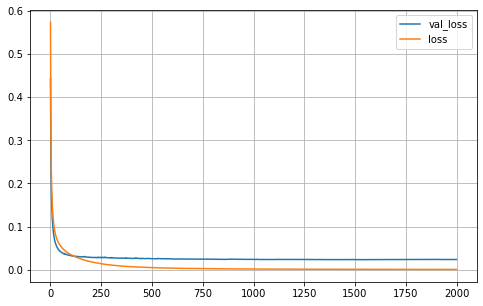

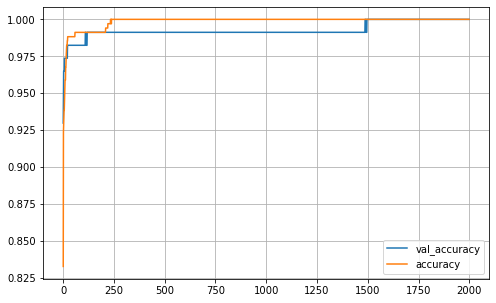

In [459]:
pd.DataFrame(history2.history)[['val_loss', 'loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.show()
pd.DataFrame(history2.history)[['val_accuracy', 'accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [460]:

dict_resultados_modelos_hiperparametrizados['rede_neural'] = new_model.evaluate(X_test, y_test)[1]
new_model.evaluate(X_test, y_test)

4/4 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.00 - 0s 3ms/step - loss: 0.1294 - accuracy: 0.9912


[0.12936705350875854, 0.9912280440330505]

### construção de um modelo base para comparação
baseado no modelo visto em aula

In [464]:
model_base = Sequential([
    
Dense(300, input_dim= X.shape[1], activation="relu"),
Dense(100, activation="relu"),
Dense(1, activation="sigmoid")
])
model_base.compile(loss="binary_crossentropy",
optimizer="sgd",
metrics=["accuracy"])
model_base.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 300)               9300      
_________________________________________________________________
dense_31 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 39,501
Trainable params: 39,501
Non-trainable params: 0
_________________________________________________________________


In [465]:
ckpt_model = 'modelo_base.best.hdf5'


callbacks_list = [checkpoint]

checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

history_base = model_base.fit(X_train, y_train, epochs=2000,
                              validation_data= (X_val, y_val),
                              callbacks=callbacks_list,
                              batch_size= 50)

Epoch 1/2000
7/7 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.48 - ETA: 0s - loss: 0.6806 - accuracy: 0.5748
Epoch 00001: val_accuracy improved from -inf to 0.83333, saving model to modelo_base.best.hdf5
7/7 [==============================] - 0s 27ms/step - loss: 0.6806 - accuracy: 0.5748 - val_loss: 0.6075 - val_accuracy: 0.8333
Epoch 2/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.5942 - accuracy: 0.8200
Epoch 00002: val_accuracy improved from 0.83333 to 0.95614, saving model to modelo_base.best.hdf5
7/7 [==============================] - 0s 12ms/step - loss: 0.5785 - accuracy: 0.8592 - val_loss: 0.5239 - val_accuracy: 0.9561
Epoch 3/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.5158 - accuracy: 0.9600
Epoch 00003: val_accuracy improved from 0.95614 to 0.96491, saving model to modelo_base.best.hdf5
7/7 [==============================] - 0s 11ms/step - loss: 0.5071 - accuracy: 0.9208 - val_loss: 0.4622 - val_accuracy: 0.9649
E

Epoch 30/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.1063 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.97368
7/7 [==============================] - 0s 10ms/step - loss: 0.1503 - accuracy: 0.9736 - val_loss: 0.1204 - val_accuracy: 0.9737
Epoch 31/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.1147 - accuracy: 0.9800
Epoch 00031: val_accuracy did not improve from 0.97368
7/7 [==============================] - 0s 9ms/step - loss: 0.1474 - accuracy: 0.9736 - val_loss: 0.1175 - val_accuracy: 0.9737
Epoch 32/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.1358 - accuracy: 0.9600
Epoch 00032: val_accuracy did not improve from 0.97368
7/7 [==============================] - 0s 11ms/step - loss: 0.1445 - accuracy: 0.9736 - val_loss: 0.1148 - val_accuracy: 0.9737
Epoch 33/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.1469 - accuracy: 0.9600
Epoch 00033: val_accuracy did not improve from 0.97368
7/7 [============

1/7 [===>..........................] - ETA: 0s - loss: 0.0548 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 10ms/step - loss: 0.0780 - accuracy: 0.9824 - val_loss: 0.0552 - val_accuracy: 0.9912
Epoch 89/2000
5/7 [====================>.........] - ETA: 0s - loss: 0.0931 - accuracy: 0.98 - ETA: 0s - loss: 0.0797 - accuracy: 0.9840
Epoch 00089: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 15ms/step - loss: 0.0775 - accuracy: 0.9824 - val_loss: 0.0548 - val_accuracy: 0.9912
Epoch 90/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0330 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 9ms/step - loss: 0.0769 - accuracy: 0.9824 - val_loss: 0.0544 - val_accuracy: 0.9912
Epoch 91/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0948 - accuracy: 0.9400
Epoch 00091: val_accuracy did not improve fr

1/7 [===>..........................] - ETA: 0s - loss: 0.0342 - accuracy: 1.0000
Epoch 00145: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 12ms/step - loss: 0.0587 - accuracy: 0.9883 - val_loss: 0.0406 - val_accuracy: 0.9912
Epoch 146/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0740 - accuracy: 0.9800
Epoch 00146: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 10ms/step - loss: 0.0584 - accuracy: 0.9883 - val_loss: 0.0404 - val_accuracy: 0.9912
Epoch 147/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0683 - accuracy: 0.9800
Epoch 00147: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 19ms/step - loss: 0.0582 - accuracy: 0.9883 - val_loss: 0.0403 - val_accuracy: 0.9912
Epoch 148/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0604 - accuracy: 1.0000
Epoch 00148: val_accuracy did not improve from 0.99123
7/7 [======================

Epoch 203/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0275 - accuracy: 1.0000
Epoch 00203: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 12ms/step - loss: 0.0484 - accuracy: 0.9912 - val_loss: 0.0342 - val_accuracy: 0.9912
Epoch 204/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0583 - accuracy: 0.9800
Epoch 00204: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 13ms/step - loss: 0.0482 - accuracy: 0.9912 - val_loss: 0.0342 - val_accuracy: 0.9912
Epoch 205/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0678 - accuracy: 0.9800
Epoch 00205: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 14ms/step - loss: 0.0481 - accuracy: 0.9912 - val_loss: 0.0341 - val_accuracy: 0.9912
Epoch 206/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0375 - accuracy: 1.0000
Epoch 00206: val_accuracy did not improve from 0.99123
7/7 [=======

1/7 [===>..........................] - ETA: 0s - loss: 0.0601 - accuracy: 0.9800
Epoch 00261: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 10ms/step - loss: 0.0413 - accuracy: 0.9912 - val_loss: 0.0309 - val_accuracy: 0.9912
Epoch 262/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0585 - accuracy: 0.9800
Epoch 00262: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 14ms/step - loss: 0.0412 - accuracy: 0.9912 - val_loss: 0.0308 - val_accuracy: 0.9912
Epoch 263/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0163 - accuracy: 1.0000
Epoch 00263: val_accuracy did not improve from 0.99123
7/7 [==============================] - 0s 15ms/step - loss: 0.0412 - accuracy: 0.9912 - val_loss: 0.0308 - val_accuracy: 0.9912
Epoch 264/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9800
Epoch 00264: val_accuracy did not improve from 0.99123
7/7 [======================

Epoch 00319: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 16ms/step - loss: 0.0360 - accuracy: 0.9912 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 320/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0578 - accuracy: 0.9800
Epoch 00320: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0359 - accuracy: 0.9912 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 321/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0739 - accuracy: 0.9600
Epoch 00321: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0359 - accuracy: 0.9912 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 322/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0608 - accuracy: 0.9800
Epoch 00322: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 12ms/step - loss: 0.0358 - accuracy: 0.9912 - val_loss: 0.0288 - v

Epoch 378/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0461 - accuracy: 0.9800
Epoch 00378: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 16ms/step - loss: 0.0316 - accuracy: 0.9912 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 379/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0119 - accuracy: 1.0000
Epoch 00379: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0316 - accuracy: 0.9912 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 380/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0485 - accuracy: 0.9800
Epoch 00380: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0315 - accuracy: 0.9912 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 381/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0110 - accuracy: 1.0000
Epoch 00381: val_accuracy did not improve from 1.00000
7/7 [=======

Epoch 00436: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0280 - accuracy: 0.9912 - val_loss: 0.0265 - val_accuracy: 1.0000
Epoch 437/2000
5/7 [====================>.........] - ETA: 0s - loss: 0.0574 - accuracy: 0.98 - ETA: 0s - loss: 0.0272 - accuracy: 0.9920
Epoch 00437: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 18ms/step - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.0265 - val_accuracy: 1.0000
Epoch 438/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0413 - accuracy: 0.9800
Epoch 00438: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 14ms/step - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.0265 - val_accuracy: 1.0000
Epoch 439/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0379 - accuracy: 0.9800
Epoch 00439: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0279

Epoch 495/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0413 - accuracy: 0.9800
Epoch 00495: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0248 - accuracy: 0.9912 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 496/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0166 - accuracy: 1.0000
Epoch 00496: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0247 - accuracy: 0.9912 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 497/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0148 - accuracy: 1.0000
Epoch 00497: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0247 - accuracy: 0.9912 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 498/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0432 - accuracy: 0.9800
Epoch 00498: val_accuracy did not improve from 1.00000
7/7 [========

Epoch 524/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0378 - accuracy: 0.9800
Epoch 00524: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 14ms/step - loss: 0.0234 - accuracy: 0.9912 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 525/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0630 - accuracy: 0.9600
Epoch 00525: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 8ms/step - loss: 0.0234 - accuracy: 0.9912 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 526/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0144 - accuracy: 1.0000
Epoch 00526: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 12ms/step - loss: 0.0233 - accuracy: 0.9912 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 527/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0156 - accuracy: 1.0000
Epoch 00527: val_accuracy did not improve from 1.00000
7/7 [========

Epoch 00582: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0209 - accuracy: 0.9912 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 583/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0440 - accuracy: 0.9600
Epoch 00583: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0208 - accuracy: 0.9912 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 584/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0206 - accuracy: 1.0000
Epoch 00584: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0208 - accuracy: 0.9912 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 585/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9800
Epoch 00585: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0207 - accuracy: 0.9912 - val_loss: 0.0249 - va

Epoch 612/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000
Epoch 00612: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0197 - accuracy: 0.9912 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 613/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0264 - accuracy: 0.9800
Epoch 00613: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 12ms/step - loss: 0.0196 - accuracy: 0.9912 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 614/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0221 - accuracy: 1.0000
Epoch 00614: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0196 - accuracy: 0.9912 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 615/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0109 - accuracy: 1.0000
Epoch 00615: val_accuracy did not improve from 1.00000
7/7 [=======

Epoch 671/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000
Epoch 00671: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0176 - accuracy: 0.9912 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 672/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9800
Epoch 00672: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0176 - accuracy: 0.9912 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 673/2000
6/7 [========================>.....] - ETA: 0s - loss: 0.0199 - accuracy: 0.98 - ETA: 0s - loss: 0.0168 - accuracy: 0.9933
Epoch 00673: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0175 - accuracy: 0.9912 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 674/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9800
Epoch 00674: val_accuracy 

1/7 [===>..........................] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000
Epoch 00729: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0159 - accuracy: 0.9971 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 730/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0144 - accuracy: 1.0000
Epoch 00730: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0158 - accuracy: 0.9971 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 731/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000
Epoch 00731: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 17ms/step - loss: 0.0158 - accuracy: 0.9971 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 732/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000
Epoch 00732: val_accuracy did not improve from 1.00000
7/7 [======================

1/7 [===>..........................] - ETA: 0s - loss: 0.0372 - accuracy: 1.0000
Epoch 00787: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 21ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 788/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000
Epoch 00788: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 20ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 789/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0176 - accuracy: 1.0000
Epoch 00789: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 12ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 790/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0133 - accuracy: 1.0000
Epoch 00790: val_accuracy did not improve from 1.00000
7/7 [======================

Epoch 816/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000
Epoch 00816: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 1.0000
Epoch 817/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0301 - accuracy: 1.0000
Epoch 00817: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 14ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 1.0000
Epoch 818/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0245 - accuracy: 1.0000
Epoch 00818: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 1.0000
Epoch 819/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0268 - accuracy: 1.0000
Epoch 00819: val_accuracy did not improve from 1.00000
7/7 [=======

1/7 [===>..........................] - ETA: 0s - loss: 0.0224 - accuracy: 1.0000
Epoch 00874: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 875/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 00875: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 876/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000
Epoch 00876: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 17ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 877/2000
6/7 [========================>.....] - ETA: 0s - loss: 0.0053 - accuracy: 1.00 - ETA: 0s - loss: 0.0128 - accuracy: 1.0000
Epoch 00877: val_accuracy did not improv

Epoch 903/2000
7/7 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.00 - ETA: 0s - loss: 0.0117 - accuracy: 1.0000
Epoch 00903: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 18ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 1.0000
Epoch 904/2000
2/7 [=======>......................] - ETA: 0s - loss: 0.0177 - accuracy: 1.00 - ETA: 0s - loss: 0.0132 - accuracy: 1.0000
Epoch 00904: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 23ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 1.0000
Epoch 905/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0228 - accuracy: 1.0000
Epoch 00905: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 906/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0091 - a

Epoch 932/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0118 - accuracy: 1.0000
Epoch 00932: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 933/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0139 - accuracy: 1.0000
Epoch 00933: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 12ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 1.0000
Epoch 934/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0158 - accuracy: 1.0000
Epoch 00934: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 1.0000
Epoch 935/2000
5/7 [====================>.........] - ETA: 0s - loss: 0.0154 - accuracy: 1.00 - ETA: 0s - loss: 0.0109 - accuracy: 1.0000
Epoch 00935: val_accuracy

Epoch 00990: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 991/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000
Epoch 00991: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 992/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 00992: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 993/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0097 - accuracy: 1.0000
Epoch 00993: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0217 - val_

7/7 [==============================] - 0s 9ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 1049/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000
Epoch 01049: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 1050/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000
Epoch 01050: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 1051/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000
Epoch 01051: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 8ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 1052/2000
1/7 [===>..........

Epoch 1078/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000
Epoch 01078: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 1079/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0228 - accuracy: 1.0000
Epoch 01079: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 1080/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000
Epoch 01080: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 7ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 1081/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000
Epoch 01081: val_accuracy did not improve from 1.00000
7/7 [====

Epoch 1107/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000
Epoch 01107: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 1108/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 01108: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 8ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 1109/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 01109: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 8ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 1110/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 01110: val_accuracy did not improve from 1.00000
7/7 [=====

Epoch 1136/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
Epoch 01136: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 16ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 1137/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000
Epoch 01137: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 1138/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000
Epoch 01138: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 1139/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000
Epoch 01139: val_accuracy did not improve from 1.00000
7/7 [===

5/7 [====================>.........] - ETA: 0s - loss: 0.0054 - accuracy: 1.00 - ETA: 0s - loss: 0.0072 - accuracy: 1.0000
Epoch 01194: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 23ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 1195/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000
Epoch 01195: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 19ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 1196/2000
6/7 [========================>.....] - ETA: 0s - loss: 0.0028 - accuracy: 1.00 - ETA: 0s - loss: 0.0066 - accuracy: 1.0000
Epoch 01196: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 16ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 1197/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0029 - accuracy: 1.

Epoch 1223/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0092 - accuracy: 1.0000
Epoch 01223: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 1224/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000
Epoch 01224: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 1225/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000
Epoch 01225: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 1226/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 01226: val_accuracy did not improve from 1.00000
7/7 [===

1/7 [===>..........................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 01281: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 7ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 1282/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000
Epoch 01282: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 1283/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000
Epoch 01283: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 1284/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 01284: val_accuracy did not improve from 1.00000
7/7 [=====================

Epoch 1310/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 01310: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 17ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 1311/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0162 - accuracy: 1.0000
Epoch 01311: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 1312/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000
Epoch 01312: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 1313/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0090 - accuracy: 1.0000
Epoch 01313: val_accuracy did not improve from 1.00000
7/7 [===

Epoch 1368/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0130 - accuracy: 1.0000
Epoch 01368: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 1.0000
Epoch 1369/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000
Epoch 01369: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 1.0000
Epoch 1370/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 01370: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 1.0000
Epoch 1371/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 01371: val_accuracy did not improve from 1.00000
7/7 [=====

Epoch 1426/2000
1/7 [===>..........................] - ETA: 0s - loss: 9.5520e-04 - accuracy: 1.0000
Epoch 01426: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 12ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 1427/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000
Epoch 01427: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 1428/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 01428: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 1429/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 01429: val_accuracy did not improve from 1.00000
7/7 

1/7 [===>..........................] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000
Epoch 01484: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 14ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 1.0000
Epoch 1485/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000
Epoch 01485: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 17ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 1.0000
Epoch 1486/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 01486: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 1.0000
Epoch 1487/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 01487: val_accuracy did not improve from 1.00000
7/7 [===================

1/7 [===>..........................] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000
Epoch 01542: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 8ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 1543/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0092 - accuracy: 1.0000
Epoch 01543: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 1544/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000
Epoch 01544: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 1545/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 01545: val_accuracy did not improve from 1.00000
7/7 [====================

Epoch 1600/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 01600: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 1601/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000
Epoch 01601: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 1.0000
Epoch 1602/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000
Epoch 01602: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 1603/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000
Epoch 01603: val_accuracy did not improve from 1.00000
7/7 [=====

Epoch 1658/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000
Epoch 01658: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 8ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 1659/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 01659: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 1660/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000
Epoch 01660: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 1661/2000
1/7 [===>..........................] - ETA: 0s - loss: 8.2271e-04 - accuracy: 1.0000
Epoch 01661: val_accuracy did not improve from 1.00000
7/7 [

1/7 [===>..........................] - ETA: 0s - loss: 8.1765e-04 - accuracy: 1.0000
Epoch 01716: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 1717/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 01717: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 10ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 1718/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000
Epoch 01718: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 1719/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000
Epoch 01719: val_accuracy did not improve from 1.00000
7/7 [===============

1/7 [===>..........................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000
Epoch 01774: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 15ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 1775/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000
Epoch 01775: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 16ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 1776/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 01776: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 12ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 1777/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000
Epoch 01777: val_accuracy did not improve from 1.00000
7/7 [===================

1/7 [===>..........................] - ETA: 0s - loss: 0.0133 - accuracy: 1.0000
Epoch 01832: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 1833/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000
Epoch 01833: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 1834/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 01834: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 1835/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 01835: val_accuracy did not improve from 1.00000
7/7 [=====================

1/7 [===>..........................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 01890: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 12ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 1891/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000
Epoch 01891: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 1892/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 01892: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 1893/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 01893: val_accuracy did not improve from 1.00000
7/7 [====================

1/7 [===>..........................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000
Epoch 01948: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 1949/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000
Epoch 01949: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 1950/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000
Epoch 01950: val_accuracy did not improve from 1.00000
7/7 [==============================] - 0s 9ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 1951/2000
1/7 [===>..........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000
Epoch 01951: val_accuracy did not improve from 1.00000
7/7 [====================

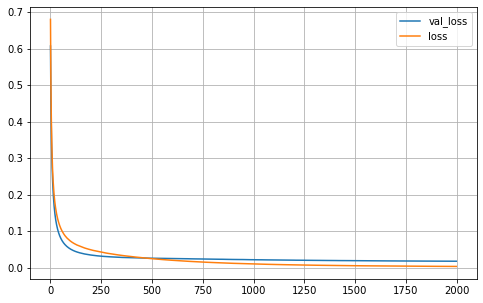

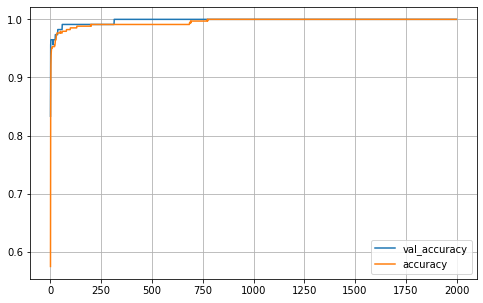

In [466]:
pd.DataFrame(history_base.history)[['val_loss', 'loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.show()
pd.DataFrame(history_base.history)[['val_accuracy', 'accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [467]:
dict_resultados_modelos_n_hiperparametrizados['rede_neural'] = model_base.evaluate(X_test, y_test)[1]

model_base.evaluate(X_test, y_test)


4/4 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 1.00 - 0s 5ms/step - loss: 0.1107 - accuracy: 0.9912


[0.11069529503583908, 0.9912280440330505]

In [468]:
df_resultados = pd.DataFrame([dict_resultados_modelos_hiperparametrizados, 
                              dict_resultados_modelos_n_hiperparametrizados]).transpose()
df_resultados.columns = ['busc. hiperparam', 'padrão']

In [469]:
df_resultados

,busc. hiperparam,padrão
logistic_regression,0.973684,0.973684
decision_tree,0.956140,0.956140
xgboost,0.973684,0.982456
rede_neural,0.991228,0.991228
